In [ ]:
# # !gcc -v
# print(torch.__version__)
# print(torch.version.cuda)
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.1+cu111.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.9.1+cu111.html
# !pip install torch-geometric

In [1]:
# import pickle
# import pandas as pd
# import torch

# class Data_old(object):
#     def __init__(self, node_features, global_features, node_vals, graph, train_mask, valid_mask, test_mask):
#         super(Data, self).__init__()
#         self.x = node_features
#         self.glob = global_features
#         self.y = node_vals
#         self.nodes = graph.nodes
#         self.edges = graph.edges
#         self.idx2number = graph.idx2number
#         self.idx2name = graph.idx2name
#         self.idx2coord = graph.idx2coord
#         self.train_mask = train_mask
#         self.valid_mask = valid_mask
#         self.test_mask = test_mask
#     def to(self, dev):
#         self.x = self.x.to(dev)
#         self.glob = self.glob.to(dev)
#         self.y = self.y.to(dev)
#         self.nodes = self.nodes.to(dev)
#         self.edges = self.edges.to(dev)
#         self.train_mask = self.train_mask.to(dev)
#         self.valid_mask = self.valid_mask.to(dev)
#         self.test_mask = self.test_mask.to(dev)

# # node_feat = torch.load('input_60m_2017.pt')
# # glob_feat = torch.load('calendar_2017_60m_features.pt')
# # response = torch.load('response_60m_2017.pt')

# with open('dataset_2017_1h_exit_od.pkl', 'rb') as f:
#     dataset = pickle.load(f)
# dataset

In [2]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch.utils.data import random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
# import pandas as pd

In [3]:
class Graph(object):
    def __init__(self, node_list, edge_list, dict_idx2number, dict_idx2name, dict_idx2coord):
        super(Graph, self).__init__()
        self.nodes = node_list
        self.edges = edge_list
        self.idx2number = dict_idx2number
        self.idx2name = dict_idx2name
        self.idx2coord = dict_idx2coord
    def to(self, dev):
        self.nodes = self.nodes.to(dev)
        self.edges = self.edges.to(dev)

def construct_graph_from_dataset(dataset):
    g = Graph(dataset.nodes, dataset.edges, dataset.idx2number, dataset.idx2name, dataset.idx2coord)
    return g

def plot_dataset(graph):
    fig, ax = plt.subplots(figsize=(25,25))

    edge_list = graph.edges.numpy()
    edges = [(x, y) for x, y in zip(edge_list[0, :], edge_list[1, :])]

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edge_list))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 100,
                'width': 1,
    }
    nx.draw(G, labels=graph.idx2name, cmap=plt.cm.tab10, font_weight='bold', pos=graph.idx2coord, **options)
    ax.set_aspect('equal', 'box')
    plt.show()

def create_masks(data):
    len_data = data.shape[0]
    
    full_dataset = torch.arange(0, len_data)
    train_size = int(0.8 * len(full_dataset))
    valid_size = int(0.1 * len(full_dataset))
    test_size = len(full_dataset) - train_size - valid_size
    train_subset, valid_subset, test_subset = random_split(full_dataset, [train_size, valid_size, test_size])

    train_mask = torch.zeros(len_data).bool()
    valid_mask = torch.zeros(len_data).bool()
    test_mask = torch.zeros(len_data).bool()

    for i in range(train_subset.__len__()):
        train_mask[train_subset.__getitem__(i)] = True
    for i in range(valid_subset.__len__()):
        valid_mask[valid_subset.__getitem__(i)] = True
    for i in range(test_subset.__len__()):
        test_mask[test_subset.__getitem__(i)] = True

    return train_mask, valid_mask, test_mask

In [4]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, node_dim=-2):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.node_dim = node_dim

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(1))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(1), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(1), x.size(1)), x=x,
                              norm=norm, node_dim=self.node_dim)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j


class Net(torch.nn.Module):
    def __init__(self, x, y, glob, num_out_feat):
        super(Net, self).__init__()
#         self.l_glob_out_features = 8
        
        self.num_node_features = x.shape[2]
        self.gcn2_features = 128
#         self.gcn3_features = 128
        self.gcn_out_features = y.shape[2]
        self.l_out_in_features = y.shape[2] + glob.shape[1] # self.l_glob_out_features # no. ODs per station + no. calendar features
        
#         self.l_glob = Linear(in_features=glob.shape[1], out_features=8)

        self.conv1 = GCNConv(self.num_node_features, self.gcn2_features, node_dim=1)
        self.conv2 = GCNConv(self.gcn2_features, self.gcn_out_features, node_dim=1)
#         self.conv3 = GCNConv(self.gcn3_features, self.gcn_out_features, node_dim=1)
        self.l_out = Linear(in_features=self.l_out_in_features, out_features=num_out_feat)

    def forward(self, x, glob, edge_list):
#         glob = self.l_glob(glob)
        
        x = self.conv1(x, edge_list)
        x = F.relu(x)
#         x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_list)
        x = F.relu(x)
#         x = self.conv3(x, edge_list)
#         x = F.relu(x)

        x = torch.cat((x, glob), dim=2)

        return F.relu(self.l_out(x))


In [5]:
class Net_FC(torch.nn.Module):
    def __init__(self, x, y, glob, num_out_feat):
        super(Net_FC, self).__init__()
        self.num_node_features = x.shape[2]
        self.fcn2_features = 128
        self.fcn3_features = 128
        self.fcn_out_features = y.shape[2]
        self.l_out_in_features = self.fcn_out_features + glob.shape[1] # no. ODs per station + no. calendar features

        self.l_1 = Linear(in_features=self.num_node_features, out_features=self.fcn2_features)
        self.l_2 = Linear(in_features=self.fcn2_features, out_features=self.fcn3_features)
        self.l_3 = Linear(in_features=self.fcn3_features, out_features=self.fcn_out_features)

        self.l_out = Linear(in_features=self.l_out_in_features, out_features=num_out_feat)
    
        self.num_nodes = x.shape[1]
        self.batchnorm = torch.nn.BatchNorm1d(self.num_nodes)

    def forward(self, x, glob, edge_list):
        
        x = self.l_1(x)
        x = F.relu(x)
#         x = self.batchnorm(x)

#         x = F.dropout(x, training=self.training)

        x = self.l_2(x)
        x = F.relu(x)
#         x = self.batchnorm(x)

        x = self.l_3(x)
        x = F.relu(x)

        x = torch.cat((x, glob), dim=2)

        return F.relu(self.l_out(x))


In [6]:
def train(x, y, glob, train_mask, valid_mask, test_mask, edge_index, net, optimizer, criterion, batch_size, num_epochs, plot=False):
#     train_mask = dataset.train_mask
#     valid_mask = dataset.valid_mask
#     test_mask = dataset.test_mask

    # Extract node feature values for training, validation and testing
    node_x_train = x[train_mask].float()
    node_x_valid = x[valid_mask].float()
    node_x_test = x[test_mask].float()

    # Extract global feature values for training, validation and testing
    global_x_train = glob[train_mask].float()
    global_x_valid = glob[valid_mask].float()
    global_x_test = glob[test_mask].float()

    # Extract response values for training, validation and testing
    y_train = y[train_mask].float()
    y_valid = y[valid_mask].float()
    y_test = y[test_mask].float()
    
    num_samples_train = node_x_train.shape[0]
    num_batches_train = num_samples_train // batch_size
    num_samples_valid = node_x_valid.shape[0]
    num_batches_valid = num_samples_valid // batch_size

    train_losses, valid_losses = list(), list()

    get_slice = lambda i, size: range(i * size, (i + 1) * size)
    
    for epoch in range(num_epochs):
        net.train()
        train_loss = 0.0
        for i in range(num_batches_train): #range(node_x_train.shape[0]):
            slce = get_slice(i, batch_size)
            # Extract data instance
            node_data = node_x_train[slce]

            # Global data for batch
            glob_data = torch.reshape(
                torch.repeat_interleave(global_x_train[slce], node_x_train.shape[1], dim=0), 
                (batch_size, node_x_train.shape[1], -1))

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            out = net(node_data, glob_data, edge_index)

            loss = criterion(out, y_train[slce])
            loss.backward()
            optimizer.step()

            train_loss += loss.data

        net.eval()
        valid_loss = 0.0
        for j in range(num_batches_valid): #range(node_x_valid.shape[0]):
            slce = get_slice(j, batch_size)
            # Extract data instance
            node_data = node_x_valid[slce]
            glob_data = torch.reshape(
                torch.repeat_interleave(global_x_valid[slce], node_x_valid.shape[1], dim=0), 
                (batch_size, node_x_valid.shape[1], -1))
            # forward + backward + optimize
            out = net(node_data, glob_data, edge_index)

            loss = criterion(out, y_valid[slce])

            valid_loss += loss.data
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if epoch + 1 == num_epochs:
            print('Epoch: {:03d}, Training Loss: {:.5f}, Validation loss: {:.5f}'.
                  format(epoch+1, train_loss/num_batches_train, valid_loss/num_batches_valid))
#         print("(training set size: ", num_batches_train, ")")
#         print("(validation set size: ", num_batches_valid, ")")

    if plot:
        plt.plot([tl/num_batches_train for tl in train_losses], label="Train loss")
        plt.plot([vl/num_batches_valid for vl in valid_losses], label="Validation loss")
        plt.xlabel("# Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.show()
    
    return train_losses, valid_losses, num_batches_train, num_batches_valid

# # No. samples for tiny dataset
# n_samples = 6400

# if False:
#     node_feat = node_feat[0:n_samples]
#     response = response[0:n_samples]
#     glob_feat = glob_feat[0:n_samples]


In [74]:
# dataset = Planetoid(root='/tmp/Cora', name='Cora')
with open('graph_simple_2017.pkl', 'rb') as f:
    graph = pickle.load(f)

# plot_dataset(graph)

###############################################################
# print("15 minutes GCN")
node_feat = torch.load('input_15m_2017.pt')
glob_feat = torch.load('calendar_2017_15m_features.pt')
response = torch.load('response_15m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

train_mask = torch.load('train_mask_15m_2017.pt')
valid_mask = torch.load('valid_mask_15m_2017.pt')
test_mask = torch.load('test_mask_15m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 100

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

# t0 = time.time()
# train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=True)
# t1 = time.time()
# print(t1-t0)

###############################################################
# # print("30 minute GCN")
# node_feat = torch.load('input_30m_2017.pt')
# glob_feat = torch.load('calendar_2017_30m_features.pt')
# response = torch.load('response_30m_2017.pt')

# n_node_features = node_feat.shape[1]
# node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
# response = torch.reshape(response, (-1,84,84))

# train_mask = torch.load('train_mask_30m_2017.pt')
# valid_mask = torch.load('valid_mask_30m_2017.pt')
# test_mask = torch.load('test_mask_30m_2017.pt')

# batch_size = glob_feat.shape[1] - 8
# num_epochs = 100

# # # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device = torch.device('cpu')
# # model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)

# # node_feat = node_feat.to(device)
# # glob_feat = glob_feat.to(device)
# # response = response.to(device)

# # edge_index = graph.edges.to(device)

# # # optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# # optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# # criterion = torch.nn.MSELoss()

# # t0 = time.time()
# # train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=True)
# # t1 = time.time()
# # print(t1-t0)

# ###############################################################
# # print("60 minute GCN")
# node_feat = torch.load('input_60m_2017.pt')
# glob_feat = torch.load('calendar_2017_60m_features.pt')
# response = torch.load('response_60m_2017.pt')

# n_node_features = node_feat.shape[1]
# node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
# response = torch.reshape(response, (-1,84,84))

# train_mask = torch.load('train_mask_60m_2017.pt')
# valid_mask = torch.load('valid_mask_60m_2017.pt')
# test_mask = torch.load('test_mask_60m_2017.pt')

# batch_size = glob_feat.shape[1] - 8
# num_epochs = 100

# # # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device = torch.device('cpu')
# # model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)

# # node_feat = node_feat.to(device)
# # glob_feat = glob_feat.to(device)
# # response = response.to(device)

# # edge_index = graph.edges.to(device)

# # # optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# # optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# # criterion = torch.nn.MSELoss()

# # t0 = time.time()
# # train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=True)
# # t1 = time.time()
# # print(t1-t0)

# ###############################################################
optimizer


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [80]:
optimizer.state_dict

<bound method Optimizer.state_dict of SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)>

In [100]:
print(glob_feat.shape)
print(node_feat.shape)
print(response.shape)

torch.Size([34368, 104])
torch.Size([34368, 84, 593])
torch.Size([34368, 84, 84])


In [173]:
node_feat = torch.load('input_15m_2017.pt')
glob_feat = torch.load('calendar_2017_15m_features.pt')
response = torch.load('response_15m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

means = node_feat.mean(dim=1, keepdim=True)
stds = node_feat[0:96].std(dim=1, keepdim=True)
# node_feat = torch.nan_to_num((node_feat - means)/stds)


In [9]:
# means = node_feat[0:96].mean(dim=0, keepdim=True)
# stds = node_feat[0:96].std(dim=0, keepdim=True)
# # (node_feat[0:96] - means)/stds
# torch.nan_to_num((node_feat[0:96] - means)/stds)

In [7]:
# (node_feat[0:96] - means)/stds

In [8]:
# torch.isnan(node_feat)

# Parameter tuning

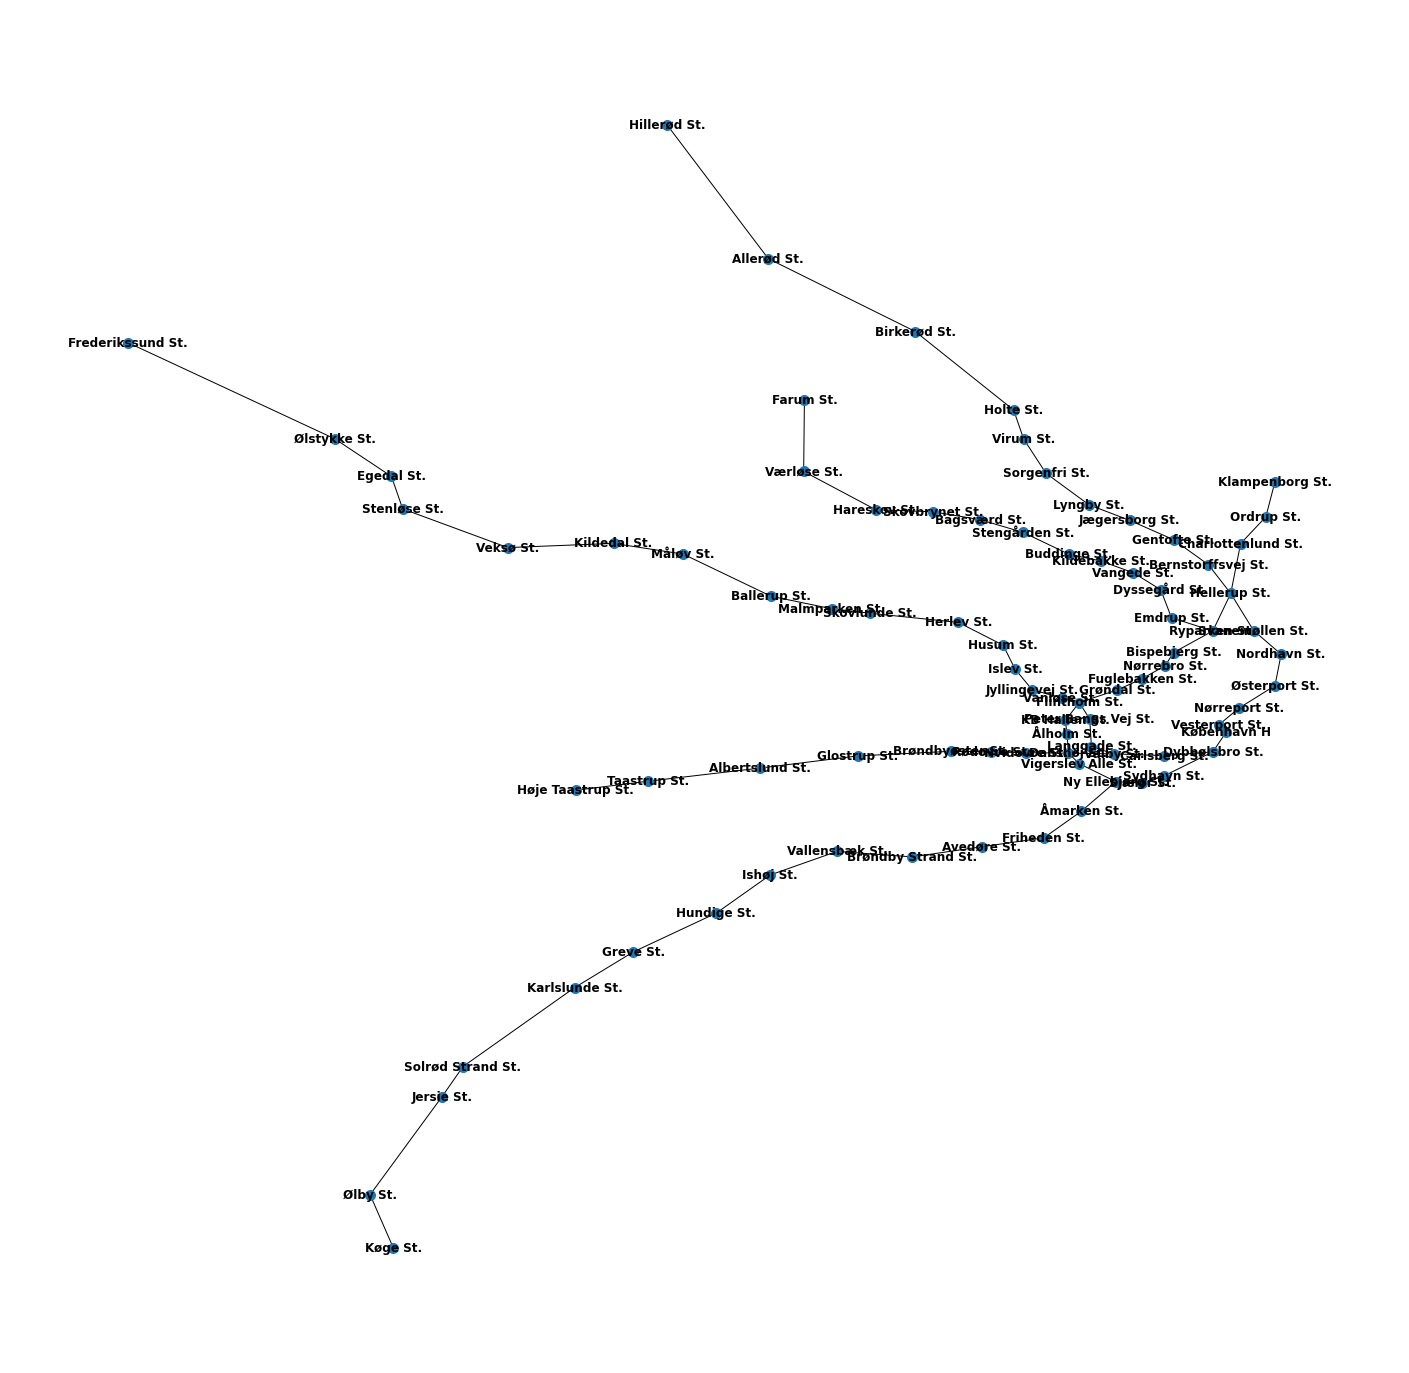

In [9]:
with open('graph_simple_2017.pkl', 'rb') as f:
    graph = pickle.load(f)

plot_dataset(graph)

## FCNN

### 60 Minutes

60 minute runs
SGD optimizer:
Learning rate:  0.001
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.92697, Validation loss: 1.95454
Iteration:  1
Epoch: 200, Training Loss: 1.87434, Validation loss: 1.89410
Iteration:  2
Epoch: 200, Training Loss: 1.74341, Validation loss: 1.77077
Iteration:  3
Epoch: 200, Training Loss: 1.93056, Validation loss: 1.96003
Iteration:  4
Epoch: 200, Training Loss: 1.76808, Validation loss: 1.79951
1264.1767036914825


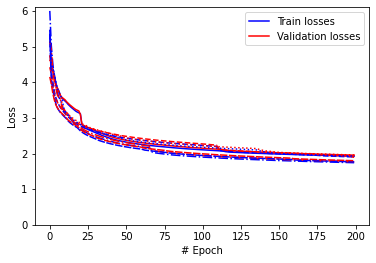

Learning rate:  0.001
Weight decay:  0
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.66125, Validation loss: 1.68155
Iteration:  1
Epoch: 200, Training Loss: 1.77583, Validation loss: 1.79684
Iteration:  2
Epoch: 200, Training Loss: 1.64491, Validation loss: 1.66660
Iteration:  3
Epoch: 200, Training Loss: 1.69465, Validation loss: 1.71733
Iteration:  4
Epoch: 200, Training Loss: 1.63881, Validation loss: 1.65732
1282.4799664020538


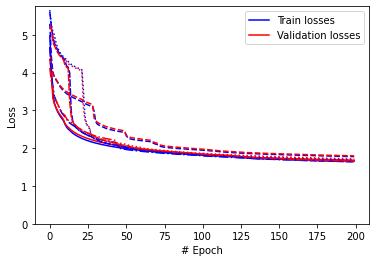

Learning rate:  0.001
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.38918, Validation loss: 1.44764
Iteration:  1
Epoch: 200, Training Loss: 1.41039, Validation loss: 1.46847
Iteration:  2
Epoch: 200, Training Loss: 1.41606, Validation loss: 1.47231
Iteration:  3
Epoch: 200, Training Loss: 1.40566, Validation loss: 1.46056
Iteration:  4
Epoch: 200, Training Loss: 1.42586, Validation loss: 1.48575
1261.0613379478455


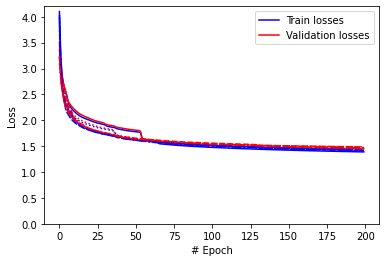

Learning rate:  0.001
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.77575, Validation loss: 1.80195
Iteration:  1
Epoch: 200, Training Loss: 1.95166, Validation loss: 1.98045
Iteration:  2
Epoch: 200, Training Loss: 1.80919, Validation loss: 1.83357
Iteration:  3
Epoch: 200, Training Loss: 1.90796, Validation loss: 1.93343
Iteration:  4
Epoch: 200, Training Loss: 1.93534, Validation loss: 1.96006
1267.824904203415


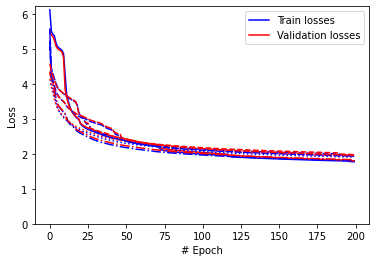

Learning rate:  0.001
Weight decay:  0.0001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.62395, Validation loss: 1.64702
Iteration:  1
Epoch: 200, Training Loss: 1.64863, Validation loss: 1.66893
Iteration:  2
Epoch: 200, Training Loss: 1.64958, Validation loss: 1.67096
Iteration:  3
Epoch: 200, Training Loss: 1.65428, Validation loss: 1.67477
Iteration:  4
Epoch: 200, Training Loss: 1.66998, Validation loss: 1.68850
1307.2493500709534


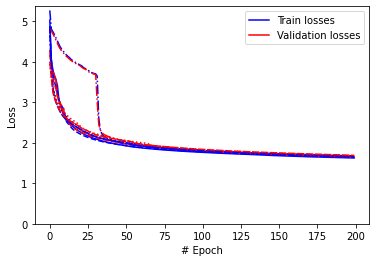

Learning rate:  0.001
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.38458, Validation loss: 1.43968
Iteration:  1
Epoch: 200, Training Loss: 1.41692, Validation loss: 1.47564
Iteration:  2
Epoch: 200, Training Loss: 1.42599, Validation loss: 1.48055
Iteration:  3
Epoch: 200, Training Loss: 1.38991, Validation loss: 1.43874
Iteration:  4
Epoch: 200, Training Loss: 1.39457, Validation loss: 1.44441
1294.939932346344


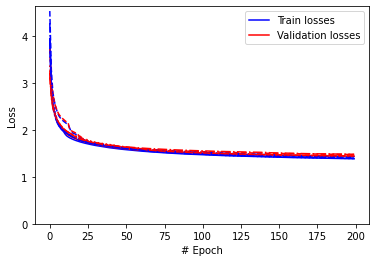

Learning rate:  0.001
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.83121, Validation loss: 1.86170
Iteration:  1
Epoch: 200, Training Loss: 1.95899, Validation loss: 1.98442
Iteration:  2
Epoch: 200, Training Loss: 1.84630, Validation loss: 1.87304
Iteration:  3
Epoch: 200, Training Loss: 1.79756, Validation loss: 1.82587
Iteration:  4
Epoch: 200, Training Loss: 1.98080, Validation loss: 2.02008
1263.8437616825104


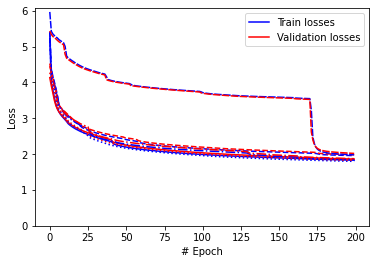

Learning rate:  0.001
Weight decay:  0.001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.69514, Validation loss: 1.71223
Iteration:  1
Epoch: 200, Training Loss: 1.63046, Validation loss: 1.65013
Iteration:  2
Epoch: 200, Training Loss: 1.89876, Validation loss: 1.91607
Iteration:  3
Epoch: 200, Training Loss: 1.70323, Validation loss: 1.72461
Iteration:  4
Epoch: 200, Training Loss: 1.69994, Validation loss: 1.72124
1294.4838576316833


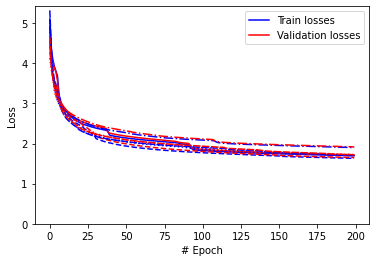

Learning rate:  0.001
Weight decay:  0.001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.42936, Validation loss: 1.47300
Iteration:  1
Epoch: 200, Training Loss: 1.43435, Validation loss: 1.47225
Iteration:  2
Epoch: 200, Training Loss: 1.41480, Validation loss: 1.46400
Iteration:  3
Epoch: 200, Training Loss: 1.41846, Validation loss: 1.46975
Iteration:  4
Epoch: 200, Training Loss: 1.42902, Validation loss: 1.47301
1284.1401765346527


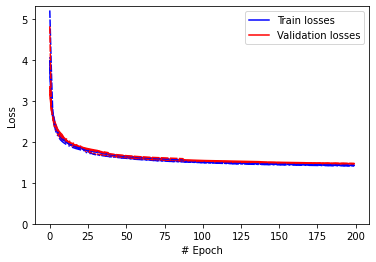

Learning rate:  0.001
Weight decay:  0.01
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.89763, Validation loss: 1.93943
Iteration:  1
Epoch: 200, Training Loss: 1.82789, Validation loss: 1.87407
Iteration:  2
Epoch: 200, Training Loss: 1.83647, Validation loss: 1.88338
Iteration:  3
Epoch: 200, Training Loss: 1.83652, Validation loss: 1.88113
Iteration:  4
Epoch: 200, Training Loss: 1.86434, Validation loss: 1.90626
1269.4748511314392


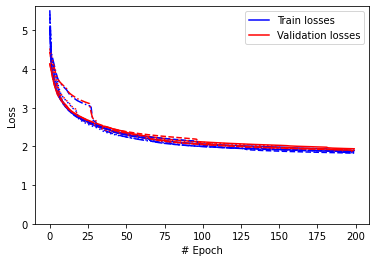

Learning rate:  0.001
Weight decay:  0.01
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.78966, Validation loss: 1.82426
Iteration:  1
Epoch: 200, Training Loss: 3.37415, Validation loss: 3.35679
Iteration:  2
Epoch: 200, Training Loss: 1.76379, Validation loss: 1.79770
Iteration:  3
Epoch: 200, Training Loss: 1.72767, Validation loss: 1.76358
Iteration:  4
Epoch: 200, Training Loss: 1.80058, Validation loss: 1.83241
1301.702111005783


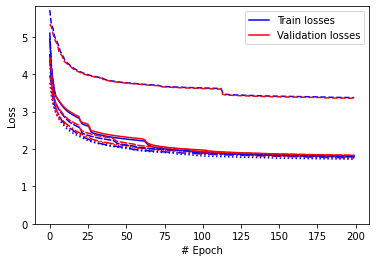

Learning rate:  0.001
Weight decay:  0.01
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.64847, Validation loss: 1.67614
Iteration:  1
Epoch: 200, Training Loss: 1.65064, Validation loss: 1.68125
Iteration:  2
Epoch: 200, Training Loss: 1.65029, Validation loss: 1.68069
Iteration:  3
Epoch: 200, Training Loss: 1.65496, Validation loss: 1.68212
Iteration:  4
Epoch: 200, Training Loss: 1.64829, Validation loss: 1.67518
1289.6068668365479


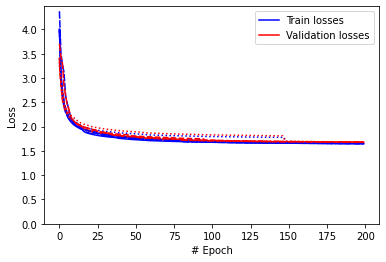

Learning rate:  0.01
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.39193, Validation loss: 1.44567
Iteration:  1
Epoch: 200, Training Loss: 1.45395, Validation loss: 1.50753
Iteration:  2
Epoch: 200, Training Loss: 1.39980, Validation loss: 1.45058
Iteration:  3
Epoch: 200, Training Loss: 1.41439, Validation loss: 1.46568
Iteration:  4
Epoch: 200, Training Loss: 1.40044, Validation loss: 1.45225
1261.175367116928


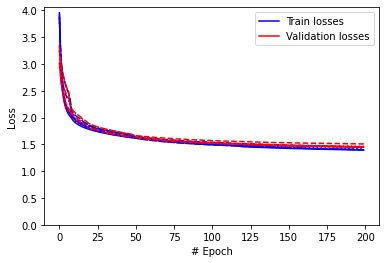

Learning rate:  0.01
Weight decay:  0
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.32461, Validation loss: 1.43696
Iteration:  1
Epoch: 200, Training Loss: 1.34215, Validation loss: 1.45028
Iteration:  2
Epoch: 200, Training Loss: 1.33052, Validation loss: 1.43108
Iteration:  3
Epoch: 200, Training Loss: 1.35355, Validation loss: 1.46684
Iteration:  4
Epoch: 200, Training Loss: 1.34142, Validation loss: 1.44711
1287.387523174286


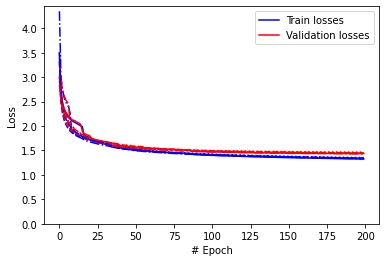

Learning rate:  0.01
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.25838, Validation loss: 1.42300
Iteration:  1
Epoch: 200, Training Loss: 1.26389, Validation loss: 1.42679
Iteration:  2
Epoch: 200, Training Loss: 1.27012, Validation loss: 1.44814
Iteration:  3
Epoch: 200, Training Loss: 1.25906, Validation loss: 1.42898
Iteration:  4
Epoch: 200, Training Loss: 1.26262, Validation loss: 1.42757
1292.8668031692505


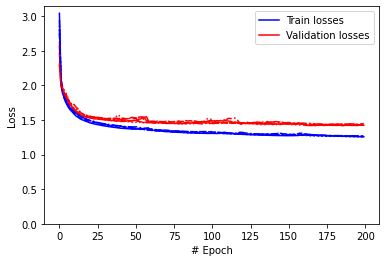

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.43866, Validation loss: 1.48761
Iteration:  1
Epoch: 200, Training Loss: 1.39023, Validation loss: 1.44038
Iteration:  2
Epoch: 200, Training Loss: 1.39609, Validation loss: 1.45291
Iteration:  3
Epoch: 200, Training Loss: 1.40544, Validation loss: 1.45543
Iteration:  4
Epoch: 200, Training Loss: 1.39824, Validation loss: 1.44627
1287.2790534496307


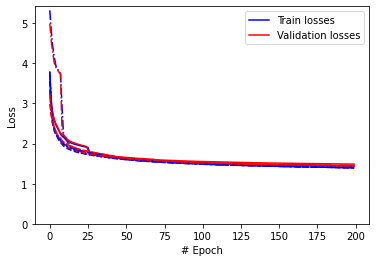

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.32881, Validation loss: 1.43682
Iteration:  1
Epoch: 200, Training Loss: 1.33269, Validation loss: 1.42782
Iteration:  2
Epoch: 200, Training Loss: 1.40170, Validation loss: 1.50018
Iteration:  3
Epoch: 200, Training Loss: 1.32606, Validation loss: 1.42527
Iteration:  4
Epoch: 200, Training Loss: 1.38526, Validation loss: 1.49458
1297.8247063159943


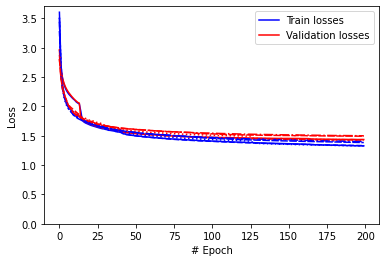

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.27644, Validation loss: 1.45109
Iteration:  1
Epoch: 200, Training Loss: 1.26382, Validation loss: 1.43835
Iteration:  2
Epoch: 200, Training Loss: 1.26624, Validation loss: 1.43092
Iteration:  3
Epoch: 200, Training Loss: 1.27931, Validation loss: 1.47070
Iteration:  4
Epoch: 200, Training Loss: 1.27305, Validation loss: 1.43408
1281.2072441577911


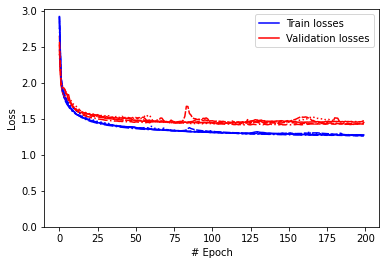

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.42754, Validation loss: 1.47497
Iteration:  1
Epoch: 200, Training Loss: 1.42443, Validation loss: 1.46640
Iteration:  2
Epoch: 200, Training Loss: 1.50528, Validation loss: 1.54937
Iteration:  3
Epoch: 200, Training Loss: 1.47863, Validation loss: 1.52049
Iteration:  4
Epoch: 200, Training Loss: 1.45330, Validation loss: 1.49365
1276.9417979717255


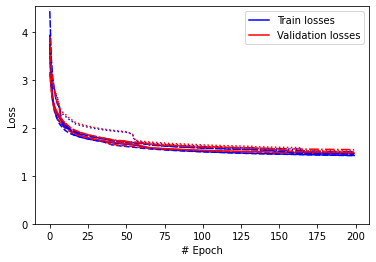

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.38121, Validation loss: 1.47457
Iteration:  1
Epoch: 200, Training Loss: 1.36728, Validation loss: 1.45974
Iteration:  2
Epoch: 200, Training Loss: 1.37793, Validation loss: 1.46910
Iteration:  3
Epoch: 200, Training Loss: 1.37061, Validation loss: 1.45282
Iteration:  4
Epoch: 200, Training Loss: 1.37688, Validation loss: 1.45896
1297.2022585868835


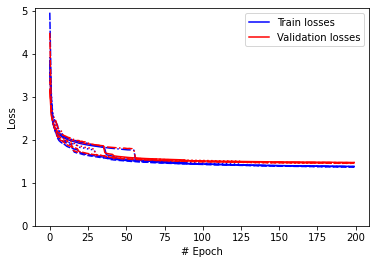

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.37064, Validation loss: 1.49534
Iteration:  1
Epoch: 200, Training Loss: 1.38511, Validation loss: 1.49370
Iteration:  2
Epoch: 200, Training Loss: 1.37405, Validation loss: 1.49415
Iteration:  3
Epoch: 200, Training Loss: 1.37047, Validation loss: 1.49547
Iteration:  4
Epoch: 200, Training Loss: 1.36199, Validation loss: 1.48541
1288.1808953285217


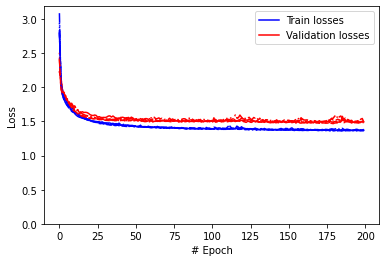

Learning rate:  0.01
Weight decay:  0.01
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.66675, Validation loss: 1.69124
Iteration:  1
Epoch: 200, Training Loss: 1.66972, Validation loss: 1.69724
Iteration:  2
Epoch: 200, Training Loss: 1.66653, Validation loss: 1.69340
Iteration:  3
Epoch: 200, Training Loss: 1.66437, Validation loss: 1.69541
Iteration:  4
Epoch: 200, Training Loss: 1.66761, Validation loss: 1.69547
1284.5110249519348


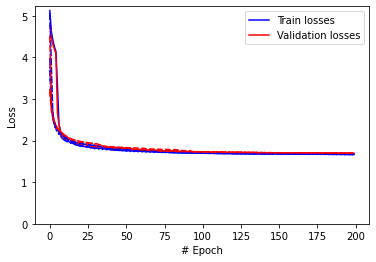

Learning rate:  0.01
Weight decay:  0.01
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.65767, Validation loss: 1.71278
Iteration:  1
Epoch: 200, Training Loss: 1.66015, Validation loss: 1.72007
Iteration:  2
Epoch: 200, Training Loss: 1.65925, Validation loss: 1.71194
Iteration:  3
Epoch: 200, Training Loss: 1.66231, Validation loss: 1.71262
Iteration:  4
Epoch: 200, Training Loss: 1.65942, Validation loss: 1.71580
1294.6609406471252


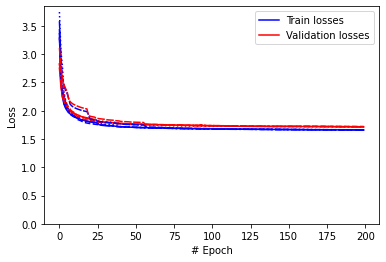

Learning rate:  0.01
Weight decay:  0.01
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.75440, Validation loss: 1.79471
Iteration:  1
Epoch: 200, Training Loss: 1.74940, Validation loss: 1.79738
Iteration:  2
Epoch: 200, Training Loss: 1.75074, Validation loss: 1.79977
Iteration:  3
Epoch: 200, Training Loss: 1.75316, Validation loss: 1.81402
Iteration:  4
Epoch: 200, Training Loss: 1.75374, Validation loss: 1.79469
1315.1918141841888


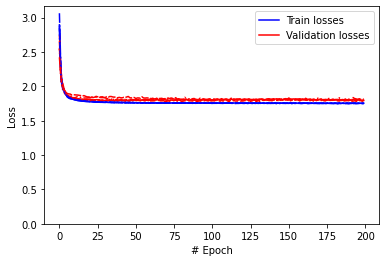

Learning rate:  0.1
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  1
Epoch: 200, Training Loss: 6.83312, Validation loss: 6.76775
Iteration:  2
Epoch: 200, Training Loss: 2.02685, Validation loss: 2.75380
Iteration:  3
Epoch: 200, Training Loss: 2.96125, Validation loss: 3.36899
Iteration:  4
Epoch: 200, Training Loss: 6.83324, Validation loss: 6.76789
1314.8884949684143


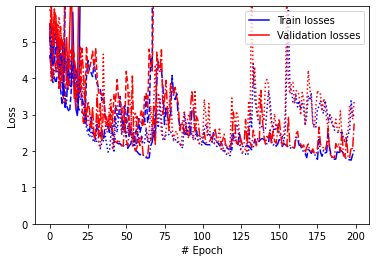

Learning rate:  0.1
Weight decay:  0
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  1
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  2
Epoch: 200, Training Loss: 3.08711, Validation loss: 3.09969
Iteration:  3
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  4
Epoch: 200, Training Loss: 6.83324, Validation loss: 6.76789
1323.5503859519958


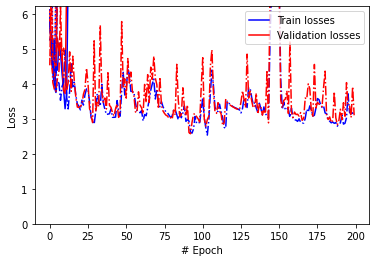

Learning rate:  0.1
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 5.33414, Validation loss: 5.27064
Iteration:  1
Epoch: 200, Training Loss: 4.57868, Validation loss: 4.53035
Iteration:  2
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  3
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  4
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
1290.90589261055


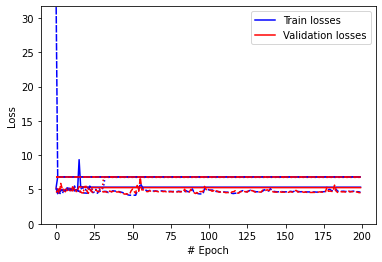

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 6.83324, Validation loss: 6.76789
Iteration:  1
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  2
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  3
Epoch: 200, Training Loss: 2.49826, Validation loss: 2.31755
Iteration:  4
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
1275.4062156677246


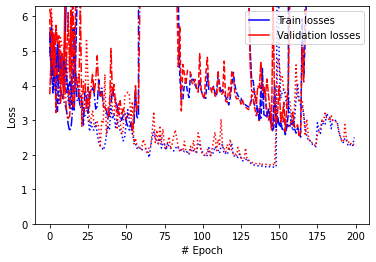

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 6.83318, Validation loss: 6.76782
Iteration:  1
Epoch: 200, Training Loss: 2.93015, Validation loss: 3.45408
Iteration:  2
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  3
Epoch: 200, Training Loss: 5.33880, Validation loss: 5.27032
Iteration:  4
Epoch: 200, Training Loss: 3.35527, Validation loss: 3.31618
1299.443862915039


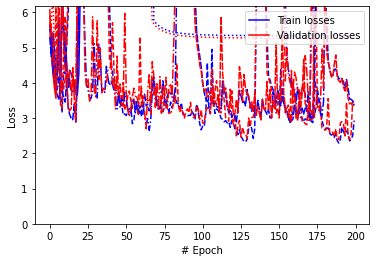

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 4.18230, Validation loss: 4.49968
Iteration:  1
Epoch: 200, Training Loss: 4.53192, Validation loss: 4.74235
Iteration:  2
Epoch: 200, Training Loss: 4.88787, Validation loss: 4.80773
Iteration:  3
Epoch: 200, Training Loss: 4.90485, Validation loss: 4.83832
Iteration:  4
Epoch: 200, Training Loss: 4.27715, Validation loss: 4.59939
1294.0278766155243


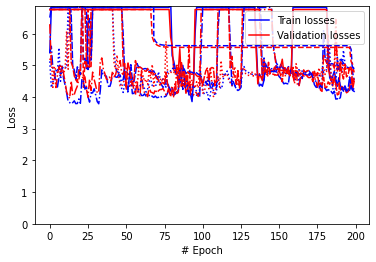

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 6.83324, Validation loss: 6.76789
Iteration:  1
Epoch: 200, Training Loss: 3.73558, Validation loss: 4.68700
Iteration:  2
Epoch: 200, Training Loss: 4.48788, Validation loss: 4.39933
Iteration:  3
Epoch: 200, Training Loss: 4.22933, Validation loss: 4.13782
Iteration:  4
Epoch: 200, Training Loss: 5.48120, Validation loss: 5.41869
1275.438604593277


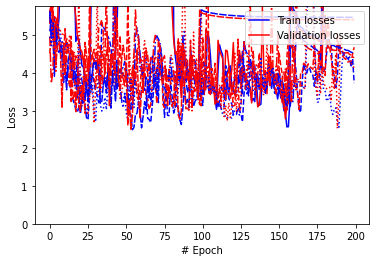

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 4.80789, Validation loss: 4.72011
Iteration:  1
Epoch: 200, Training Loss: 3.86239, Validation loss: 3.94719
Iteration:  2
Epoch: 200, Training Loss: 5.56007, Validation loss: 5.49585
Iteration:  3
Epoch: 200, Training Loss: 5.48015, Validation loss: 5.41667
Iteration:  4
Epoch: 200, Training Loss: 5.48027, Validation loss: 5.41679
1279.098360300064


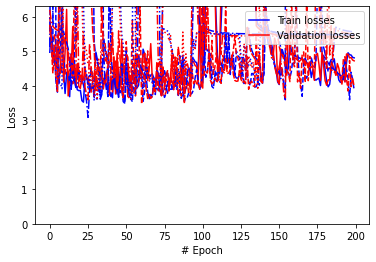

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 5.48489, Validation loss: 5.42677
Iteration:  1
Epoch: 200, Training Loss: 5.75866, Validation loss: 5.69926
Iteration:  2
Epoch: 200, Training Loss: 5.48215, Validation loss: 5.42410
Iteration:  3
Epoch: 200, Training Loss: 5.48280, Validation loss: 5.42477
Iteration:  4
Epoch: 200, Training Loss: 5.50204, Validation loss: 5.44418
1305.1520097255707


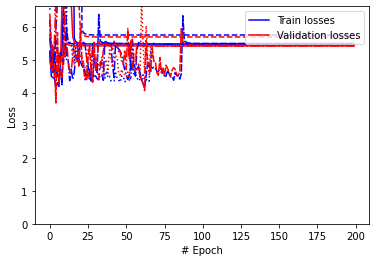

Learning rate:  0.1
Weight decay:  0.01
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 5.89995, Validation loss: 5.82977
Iteration:  1
Epoch: 200, Training Loss: 4.79446, Validation loss: 4.82018
Iteration:  2
Epoch: 200, Training Loss: 5.86001, Validation loss: 5.78944
Iteration:  3
Epoch: 200, Training Loss: 4.58118, Validation loss: 4.88750
Iteration:  4
Epoch: 200, Training Loss: 4.66382, Validation loss: 5.39115
1280.8468751907349


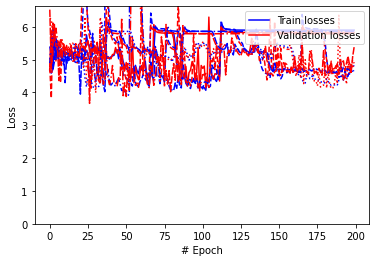

Learning rate:  0.1
Weight decay:  0.01
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 5.29870, Validation loss: 5.25217
Iteration:  1
Epoch: 200, Training Loss: 5.87551, Validation loss: 5.79709
Iteration:  2
Epoch: 200, Training Loss: 5.85993, Validation loss: 5.78142
Iteration:  3
Epoch: 200, Training Loss: 5.39705, Validation loss: 5.33897
Iteration:  4
Epoch: 200, Training Loss: 5.46156, Validation loss: 5.41454
1307.6718661785126


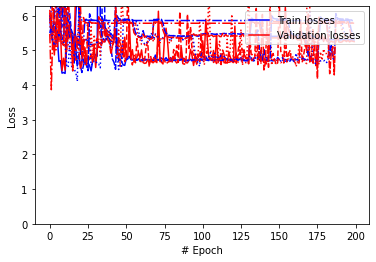

Learning rate:  0.1
Weight decay:  0.01
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 5.85894, Validation loss: 5.74413
Iteration:  1
Epoch: 200, Training Loss: 5.85894, Validation loss: 5.74413
Iteration:  2
Epoch: 200, Training Loss: 5.85894, Validation loss: 5.74413
Iteration:  3
Epoch: 200, Training Loss: 5.54927, Validation loss: 5.45328
Iteration:  4
Epoch: 200, Training Loss: 5.85894, Validation loss: 5.74413
1299.6745264530182


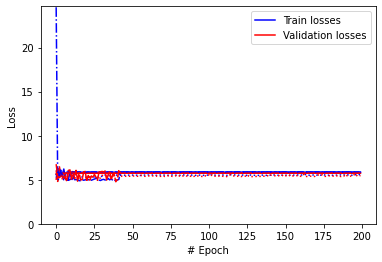

ADAM optimizer:
Learning rate:  0.001
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 1.14192, Validation loss: 1.52978
Iteration:  1
Epoch: 200, Training Loss: 1.14405, Validation loss: 1.47384
Iteration:  2
Epoch: 200, Training Loss: 1.15813, Validation loss: 1.51957
Iteration:  3
Epoch: 200, Training Loss: 1.15866, Validation loss: 1.53469
Iteration:  4
Epoch: 200, Training Loss: 1.16428, Validation loss: 1.55859
1836.1233170032501


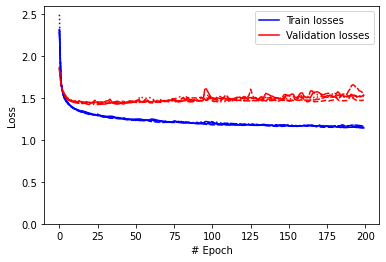

Learning rate:  0.001
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 1.18504, Validation loss: 1.44222
Iteration:  1
Epoch: 200, Training Loss: 1.18442, Validation loss: 1.46748
Iteration:  2
Epoch: 200, Training Loss: 1.18500, Validation loss: 1.44850
Iteration:  3
Epoch: 200, Training Loss: 1.18491, Validation loss: 1.44030
Iteration:  4
Epoch: 200, Training Loss: 1.18663, Validation loss: 1.44547
1840.4783554077148


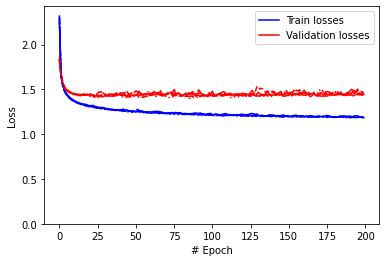

Learning rate:  0.001
Weight decay:  0.001
Iteration:  0
Epoch: 200, Training Loss: 1.32004, Validation loss: 1.43515
Iteration:  1
Epoch: 200, Training Loss: 1.32070, Validation loss: 1.43660
Iteration:  2
Epoch: 200, Training Loss: 1.31926, Validation loss: 1.45181
Iteration:  3
Epoch: 200, Training Loss: 1.31975, Validation loss: 1.43483
Iteration:  4
Epoch: 200, Training Loss: 1.32965, Validation loss: 1.42581
1831.6334714889526


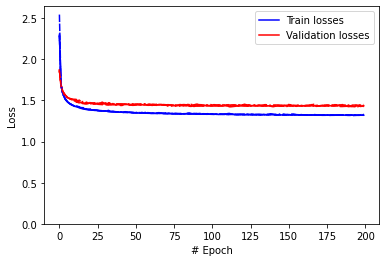

Learning rate:  0.001
Weight decay:  0.01
Iteration:  0
Epoch: 200, Training Loss: 1.64921, Validation loss: 1.69171
Iteration:  1
Epoch: 200, Training Loss: 1.65070, Validation loss: 1.69510
Iteration:  2
Epoch: 200, Training Loss: 1.65141, Validation loss: 1.70043
Iteration:  3
Epoch: 200, Training Loss: 1.64915, Validation loss: 1.69109
Iteration:  4
Epoch: 200, Training Loss: 1.64962, Validation loss: 1.69250
1830.7095320224762


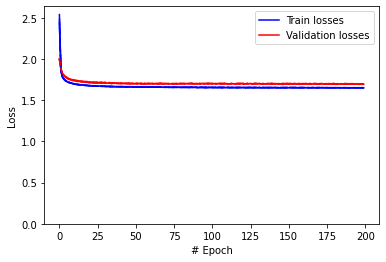

Learning rate:  0.01
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 1.41287, Validation loss: 1.77194
Iteration:  1
Epoch: 200, Training Loss: 1.46367, Validation loss: 1.73458
Iteration:  2
Epoch: 200, Training Loss: 1.42854, Validation loss: 1.74886
Iteration:  3
Epoch: 200, Training Loss: 1.42222, Validation loss: 1.78214
Iteration:  4
Epoch: 200, Training Loss: 1.43935, Validation loss: 1.72234
1813.094360589981


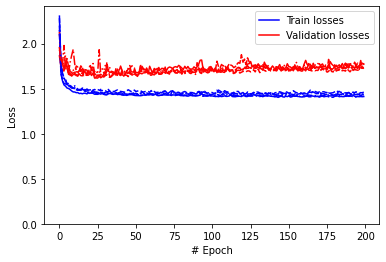

Learning rate:  0.01
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 1.49698, Validation loss: 1.64950
Iteration:  1
Epoch: 200, Training Loss: 1.51609, Validation loss: 1.70333
Iteration:  2
Epoch: 200, Training Loss: 1.50527, Validation loss: 1.75094
Iteration:  3
Epoch: 200, Training Loss: 1.51068, Validation loss: 1.67939
Iteration:  4
Epoch: 200, Training Loss: 1.48962, Validation loss: 1.67148
1860.2413911819458


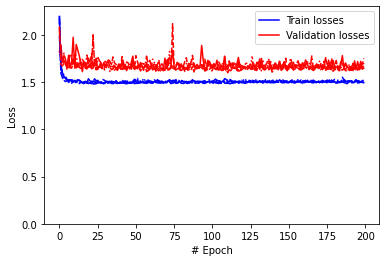

Learning rate:  0.01
Weight decay:  0.001
Iteration:  0
Epoch: 200, Training Loss: 1.59147, Validation loss: 1.68756
Iteration:  1
Epoch: 200, Training Loss: 1.58451, Validation loss: 1.74300
Iteration:  2
Epoch: 200, Training Loss: 1.60072, Validation loss: 1.70831
Iteration:  3
Epoch: 200, Training Loss: 1.59062, Validation loss: 1.72560
Iteration:  4
Epoch: 200, Training Loss: 1.60090, Validation loss: 1.74857
1841.5183413028717


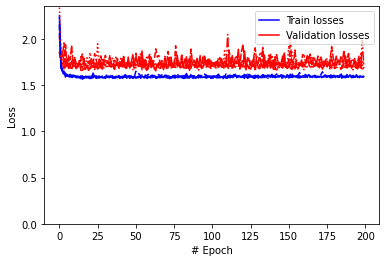

Learning rate:  0.01
Weight decay:  0.01
Iteration:  0
Epoch: 200, Training Loss: 1.83261, Validation loss: 2.05496
Iteration:  1
Epoch: 200, Training Loss: 1.83549, Validation loss: 1.93702
Iteration:  2
Epoch: 200, Training Loss: 1.83712, Validation loss: 1.95113
Iteration:  3
Epoch: 200, Training Loss: 1.83964, Validation loss: 1.96204
Iteration:  4
Epoch: 200, Training Loss: 1.83364, Validation loss: 1.96446
1842.3341598510742


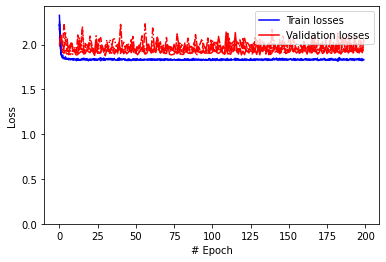

Learning rate:  0.1
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  1
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  2
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  3
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  4
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
1823.1305809020996


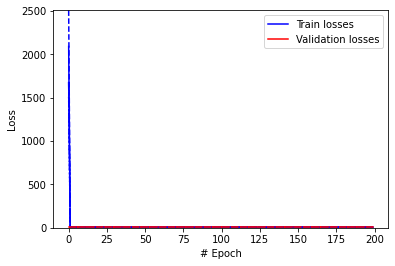

Learning rate:  0.1
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 6.10577, Validation loss: 6.06425
Iteration:  1
Epoch: 200, Training Loss: 6.14723, Validation loss: 6.10761
Iteration:  2
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  3
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  4
Epoch: 200, Training Loss: 9645.88770, Validation loss: 6.76789
1861.5257403850555


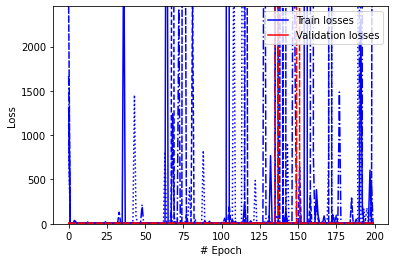

Learning rate:  0.1
Weight decay:  0.001
Iteration:  0
Epoch: 200, Training Loss: 6.09528, Validation loss: 6.03891
Iteration:  1
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  2
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  3
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  4
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
1863.1247401237488


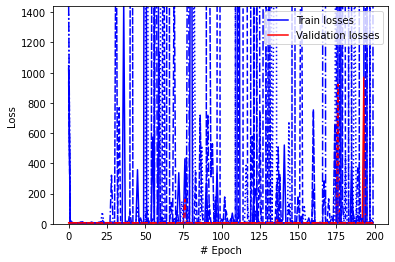

Learning rate:  0.1
Weight decay:  0.01
Iteration:  0
Epoch: 200, Training Loss: 5.93882, Validation loss: 5.85185
Iteration:  1
Epoch: 200, Training Loss: 649.45563, Validation loss: 6.76789
Iteration:  2
Epoch: 200, Training Loss: 6.83325, Validation loss: 6.76789
Iteration:  3
Epoch: 200, Training Loss: 10.83783, Validation loss: 6.76789
Iteration:  4
Epoch: 200, Training Loss: 7.49463, Validation loss: 6.74567
1873.398474931717


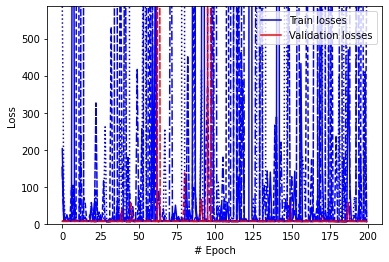

In [7]:
lrs = [0.001, 0.01, 0.1]
wds = [0, 0.0001, 0.001, 0.01]
ms = [0, 0.5, 0.9]
# lrs = [0.1]
# wds = [0]
# ms = [0]

print("60 minute runs")
node_feat = torch.load('input_60m_2017.pt')
glob_feat = torch.load('calendar_2017_60m_features.pt')
response = torch.load('response_60m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_60m_2017.pt')
valid_mask = torch.load('valid_mask_60m_2017.pt')
test_mask = torch.load('test_mask_60m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 5

print("SGD optimizer:")
for LR in lrs:
    for WD in wds:
        for M in ms:
            criterion = torch.nn.MSELoss()
            
            train_losses = []
            valid_losses = []

            print("Learning rate: ", LR)
            print("Weight decay: ", WD)
            print("Momentum: ", M)
            t0 = time.time()
            for n in range(n_iter):
                print("Iteration: ", n)
                model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
                optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
                tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
                train_losses.append(tls)
                valid_losses.append(vls)
            t1 = time.time()
            print(t1-t0)

            plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
            plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
            for m in range(1,n_iter):
                plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
                plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
            plt.show()
            

print("ADAM optimizer:")
for LR in lrs:
    for WD in wds:
        criterion = torch.nn.MSELoss()

        train_losses = []
        valid_losses = []

        print("Learning rate: ", LR)
        print("Weight decay: ", WD)
        t0 = time.time()
        for n in range(n_iter):
            print("Iteration: ", n)
            model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
            tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
            train_losses.append(tls)
            valid_losses.append(vls)
        t1 = time.time()
        print(t1-t0)

        plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
        plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
        for m in range(1,n_iter):
            plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
            plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
        plt.xlabel("# Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
        plt.show()


In [8]:
# ls = ['-','--','-.',':',(0, (5,1))]
# plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
# plt.plot([vl/nbv for vl in valid_losses[0]], color='r',label="Validation losses")
# for m in range(1,5):
#     plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
#     plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
# plt.xlabel("# Epoch")
# plt.ylabel("Loss")
# plt.legend(loc='upper right')
# plt.show()

# plt.plot([tl for tl in train_losses[0]], color='b', label="Train losses")
# plt.plot([vl for vl in valid_losses[0]], color='r',label="Validation losses")
# for m in range(1,5):
#     plt.plot([tl for tl in train_losses[m]], color='b', linestyle=ls[m])
#     plt.plot([vl for vl in valid_losses[m]], color='r', linestyle=ls[m])
# plt.xlabel("# Epoch")
# plt.ylabel("Loss")
# plt.legend(loc='upper right')
# plt.show()

In [9]:
# kss = [[0,1],[2,3]]
# # plt.plot([[k for k in ks] for ks in kss], label="Train loss")
# for i in range(2):
#     plt.plot([k for k in kss[i]], label="Train loss {}".format(i))
# plt.legend(loc='upper right')
# plt.show()

# for i in range(2):
#     plt.plot([2*k for k in kss[i]], label="Train loss {}".format(i))
# plt.legend(loc='upper right')
# plt.show()

### 30 Minutes

30 minute runs
SGD optimizer:
Learning rate:  0.1
Weight decay:  0
Momentum:  0
Epoch: 200, Training Loss: 1.93166, Validation loss: 1.91876
Epoch: 200, Training Loss: 1.92124, Validation loss: 1.90861
Epoch: 200, Training Loss: 1.91651, Validation loss: 1.90445
1762.288767337799


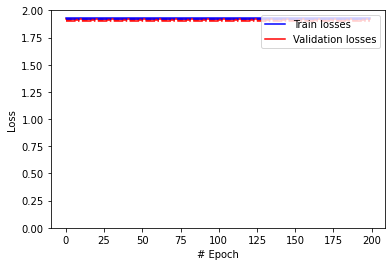

Learning rate:  0.1
Weight decay:  0
Momentum:  0.5
Epoch: 200, Training Loss: 1.89770, Validation loss: 1.88606
Epoch: 200, Training Loss: 1.90579, Validation loss: 1.89356
Epoch: 200, Training Loss: 1.90472, Validation loss: 1.89285
1769.5109450817108


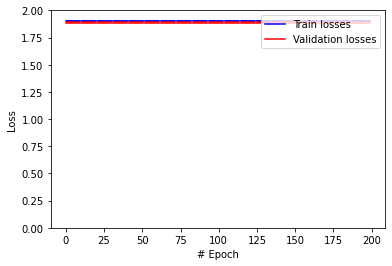

Learning rate:  0.1
Weight decay:  0
Momentum:  0.9
Epoch: 200, Training Loss: 1.92577, Validation loss: 1.91336
Epoch: 200, Training Loss: 1.91411, Validation loss: 1.90196
Epoch: 200, Training Loss: 1.91103, Validation loss: 1.89880
1799.0492897033691


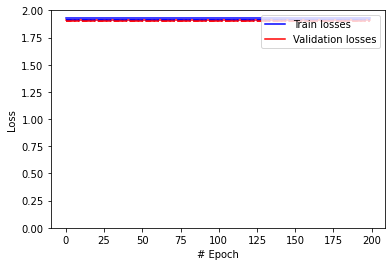

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0
Epoch: 200, Training Loss: 1.91939, Validation loss: 1.90730
Epoch: 200, Training Loss: 1.90979, Validation loss: 1.89704
Epoch: 200, Training Loss: 1.90769, Validation loss: 1.89571
1760.4676616191864


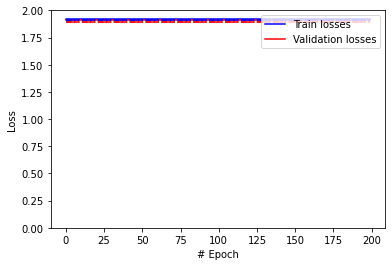

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.5
Epoch: 200, Training Loss: 1.92788, Validation loss: 1.91561
Epoch: 200, Training Loss: 1.90140, Validation loss: 1.88948
Epoch: 200, Training Loss: 1.91729, Validation loss: 1.90516
1784.150460243225


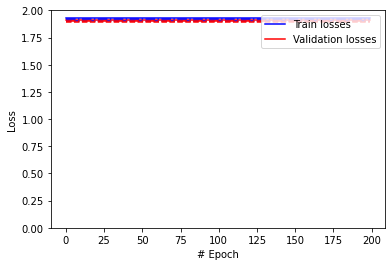

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.9
Epoch: 200, Training Loss: 1.92868, Validation loss: 1.91634
Epoch: 200, Training Loss: 1.90624, Validation loss: 1.89355
Epoch: 200, Training Loss: 1.92015, Validation loss: 1.90765
1798.1695382595062


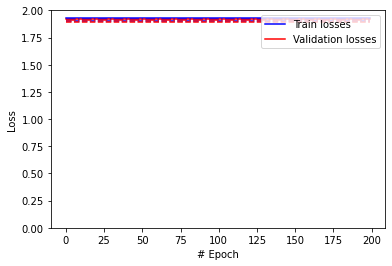

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0
Epoch: 200, Training Loss: 1.90654, Validation loss: 1.89442
Epoch: 200, Training Loss: 1.91150, Validation loss: 1.89961
Epoch: 200, Training Loss: 1.91826, Validation loss: 1.90570
1789.6290361881256


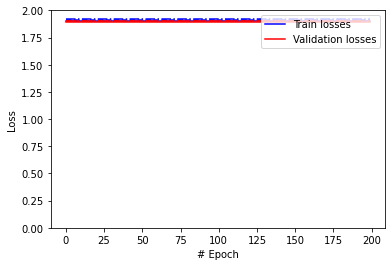

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.5
Epoch: 200, Training Loss: 1.92395, Validation loss: 1.91144
Epoch: 200, Training Loss: 1.92015, Validation loss: 1.90789
Epoch: 200, Training Loss: 1.90365, Validation loss: 1.89147
1787.786703824997


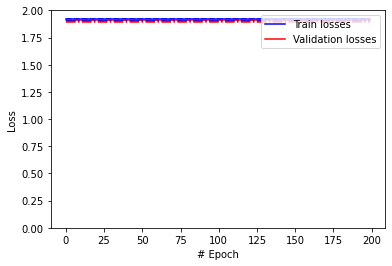

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.9
Epoch: 200, Training Loss: 1.91977, Validation loss: 1.90734
Epoch: 200, Training Loss: 1.91686, Validation loss: 1.90452
Epoch: 200, Training Loss: 1.92042, Validation loss: 1.90813
1805.7714443206787


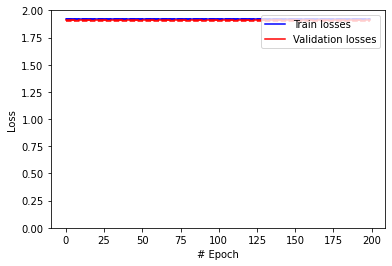

Learning rate:  0.01
Weight decay:  0
Momentum:  0
Epoch: 200, Training Loss: 1.92699, Validation loss: 1.91465
Epoch: 200, Training Loss: 1.90810, Validation loss: 1.89575
Epoch: 200, Training Loss: 1.92443, Validation loss: 1.91206
1772.3013339042664


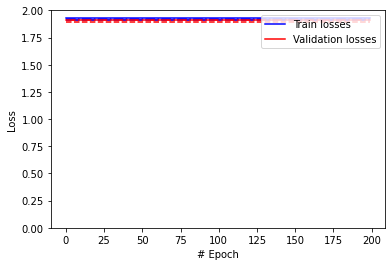

Learning rate:  0.01
Weight decay:  0
Momentum:  0.5
Epoch: 200, Training Loss: 1.91136, Validation loss: 1.89907
Epoch: 200, Training Loss: 1.91396, Validation loss: 1.90170
Epoch: 200, Training Loss: 1.90382, Validation loss: 1.89203
1802.7342154979706


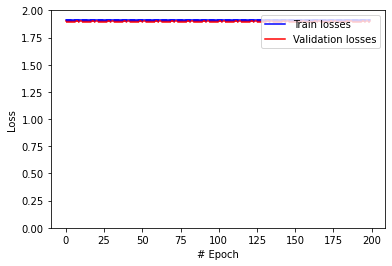

Learning rate:  0.01
Weight decay:  0
Momentum:  0.9
Epoch: 200, Training Loss: 1.90073, Validation loss: 1.88896
Epoch: 200, Training Loss: 1.92293, Validation loss: 1.91045
Epoch: 200, Training Loss: 1.90356, Validation loss: 1.89161
1791.215051651001


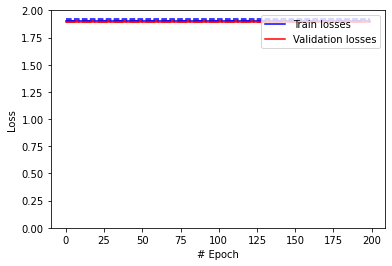

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0
Epoch: 200, Training Loss: 1.90796, Validation loss: 1.89554
Epoch: 200, Training Loss: 1.92542, Validation loss: 1.91274
Epoch: 200, Training Loss: 1.91609, Validation loss: 1.90382
1794.3374843597412


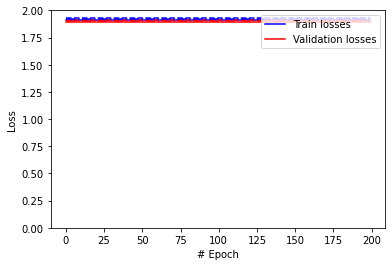

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.5
Epoch: 200, Training Loss: 1.91272, Validation loss: 1.90078
Epoch: 200, Training Loss: 1.91719, Validation loss: 1.90510
Epoch: 200, Training Loss: 1.92744, Validation loss: 1.91483
1783.2559106349945


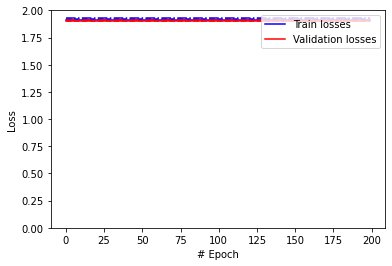

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.9
Epoch: 200, Training Loss: 1.89336, Validation loss: 1.88210
Epoch: 200, Training Loss: 1.90050, Validation loss: 1.88835
Epoch: 200, Training Loss: 1.92139, Validation loss: 1.90913
1814.271789073944


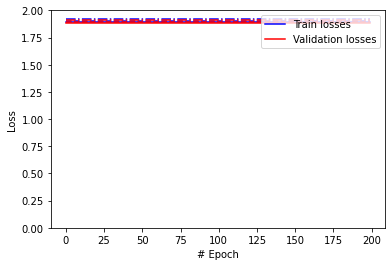

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0
Epoch: 200, Training Loss: 1.91782, Validation loss: 1.90548
Epoch: 200, Training Loss: 1.90165, Validation loss: 1.88944
Epoch: 200, Training Loss: 1.91211, Validation loss: 1.89955
1781.4088606834412


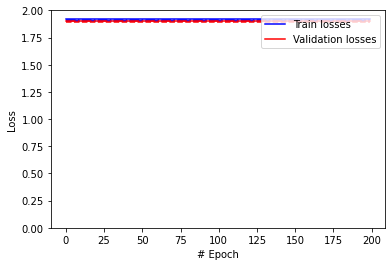

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.5
Epoch: 200, Training Loss: 1.90424, Validation loss: 1.89267
Epoch: 200, Training Loss: 1.91073, Validation loss: 1.89819
Epoch: 200, Training Loss: 1.91756, Validation loss: 1.90509
1826.7986149787903


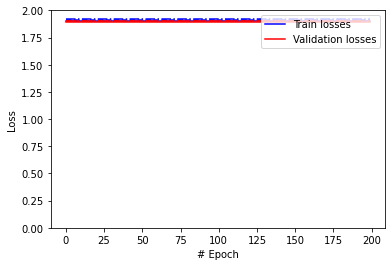

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.9
Epoch: 200, Training Loss: 1.90833, Validation loss: 1.89648
Epoch: 200, Training Loss: 1.92225, Validation loss: 1.90964
Epoch: 200, Training Loss: 1.90735, Validation loss: 1.89535
1829.2206284999847


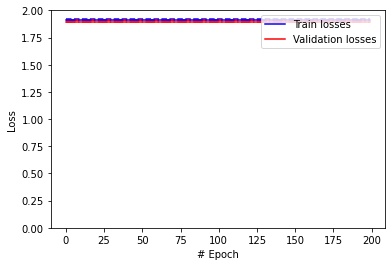

ADAM optimizer:
Learning rate:  0.01
Weight decay:  0
Epoch: 200, Training Loss: 0.60418, Validation loss: 0.64399
Epoch: 200, Training Loss: 0.59983, Validation loss: 0.62909
Epoch: 200, Training Loss: 0.60176, Validation loss: 0.64059
2211.8723232746124


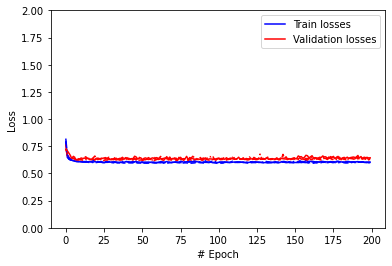

Learning rate:  0.01
Weight decay:  0.0001
Epoch: 200, Training Loss: 0.60942, Validation loss: 0.62978
Epoch: 200, Training Loss: 0.60660, Validation loss: 0.63191
Epoch: 200, Training Loss: 0.60644, Validation loss: 0.61818
2281.0420775413513


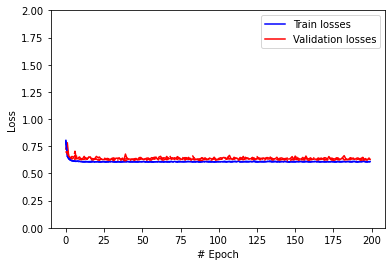

Learning rate:  0.01
Weight decay:  0.001
Epoch: 200, Training Loss: 0.64000, Validation loss: 0.65591
Epoch: 200, Training Loss: 0.63777, Validation loss: 0.65458
Epoch: 200, Training Loss: 0.63838, Validation loss: 0.65157
2269.3651690483093


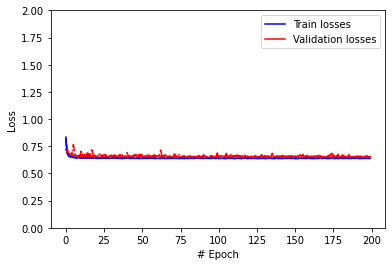

Learning rate:  0.1
Weight decay:  0
Epoch: 200, Training Loss: 1.96287, Validation loss: 1.94980
Epoch: 200, Training Loss: 1.96287, Validation loss: 1.94980
Epoch: 200, Training Loss: 1.96287, Validation loss: 1.94980
2228.47794175148


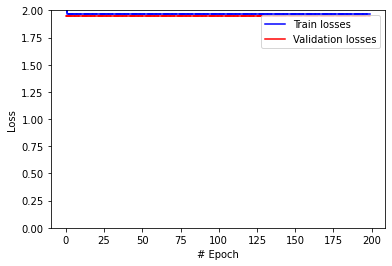

Learning rate:  0.1
Weight decay:  0.0001
Epoch: 200, Training Loss: 1.95165, Validation loss: 1.93973
Epoch: 200, Training Loss: 2813.55029, Validation loss: 1.94980
Epoch: 200, Training Loss: 1.96287, Validation loss: 1.94980
2287.442173719406


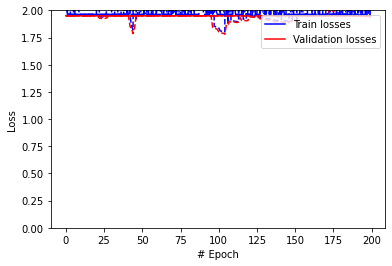

Learning rate:  0.1
Weight decay:  0.001
Epoch: 200, Training Loss: 1.92452, Validation loss: 1.89739
Epoch: 200, Training Loss: 1.94314, Validation loss: 1.93208
Epoch: 200, Training Loss: 1.96287, Validation loss: 1.94980
2314.4965081214905


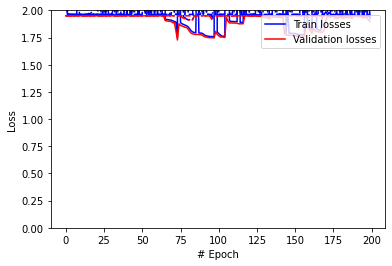

In [29]:
lrs = [0.1, 0.01]
wds = [0, 0.0001, 0.001]
ms = [0, 0.5, 0.9]

print("30 minute runs")
node_feat = torch.load('input_30m_2017.pt')
glob_feat = torch.load('calendar_2017_30m_features.pt')
response = torch.load('response_30m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_30m_2017.pt')
valid_mask = torch.load('valid_mask_30m_2017.pt')
test_mask = torch.load('test_mask_30m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 3

print("SGD optimizer:")
for LR in lrs:
    for WD in wds:
        for M in ms:
            optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
            criterion = torch.nn.MSELoss()
            
            train_losses = []
            valid_losses = []

            print("Learning rate: ", LR)
            print("Weight decay: ", WD)
            print("Momentum: ", M)
            t0 = time.time()
            for n in range(n_iter):
                model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
                tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
                train_losses.append(tls)
                valid_losses.append(vls)
            t1 = time.time()
            print(t1-t0)

            plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
            plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
            for m in range(1,n_iter):
                plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
                plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.ylim((0,2))
            plt.show()
            
lrs = [0.01, 0.1]
wds = [0, 0.0001, 0.001]

print("ADAM optimizer:")
for LR in lrs:
    for WD in wds:
        criterion = torch.nn.MSELoss()

        train_losses = []
        valid_losses = []

        print("Learning rate: ", LR)
        print("Weight decay: ", WD)
        t0 = time.time()
        for n in range(n_iter):
            model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
            tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
            train_losses.append(tls)
            valid_losses.append(vls)
        t1 = time.time()
        print(t1-t0)

        plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
        plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
        for m in range(1,n_iter):
            plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
            plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
        plt.xlabel("# Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.ylim((0,2))
        plt.show()


### 15 Minutes

15 minute runs
SGD optimizer:
Learning rate:  0.1
Weight decay:  0
Momentum:  0
Epoch: 200, Training Loss: 0.59518, Validation loss: 0.59204
Epoch: 200, Training Loss: 0.59562, Validation loss: 0.59248
Epoch: 200, Training Loss: 0.59300, Validation loss: 0.58985
3574.744795322418


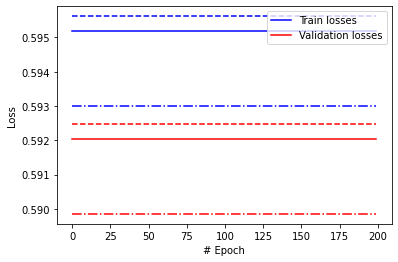

Learning rate:  0.1
Weight decay:  0
Momentum:  0.5
Epoch: 200, Training Loss: 0.59454, Validation loss: 0.59134
Epoch: 200, Training Loss: 0.59169, Validation loss: 0.58855
Epoch: 200, Training Loss: 0.58969, Validation loss: 0.58657
3624.0022914409637


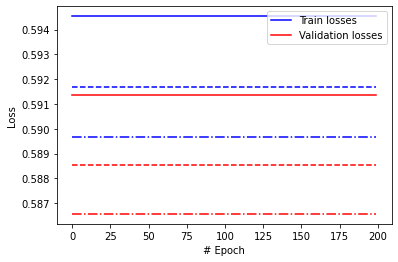

Learning rate:  0.1
Weight decay:  0
Momentum:  0.9
Epoch: 200, Training Loss: 0.59924, Validation loss: 0.59606
Epoch: 200, Training Loss: 0.59274, Validation loss: 0.58972
Epoch: 200, Training Loss: 0.59557, Validation loss: 0.59238
3617.984147310257


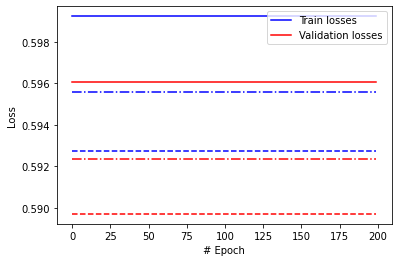

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0
Epoch: 200, Training Loss: 0.59256, Validation loss: 0.58947
Epoch: 200, Training Loss: 0.59960, Validation loss: 0.59637
Epoch: 200, Training Loss: 0.59661, Validation loss: 0.59348
3610.4956438541412


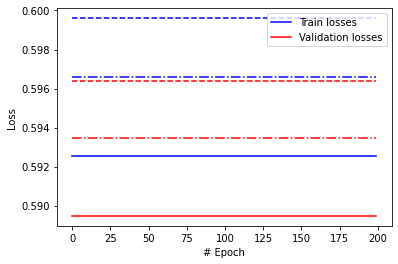

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.5
Epoch: 200, Training Loss: 0.59218, Validation loss: 0.58911
Epoch: 200, Training Loss: 0.59610, Validation loss: 0.59292
Epoch: 200, Training Loss: 0.59755, Validation loss: 0.59434
3661.159285068512


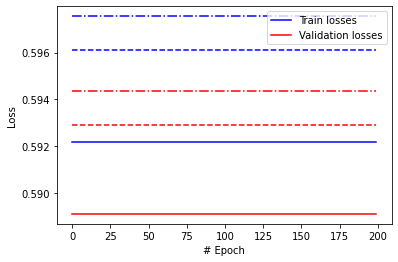

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.9
Epoch: 200, Training Loss: 0.59820, Validation loss: 0.59499
Epoch: 200, Training Loss: 0.58956, Validation loss: 0.58641
Epoch: 200, Training Loss: 0.59124, Validation loss: 0.58811
3666.8833751678467


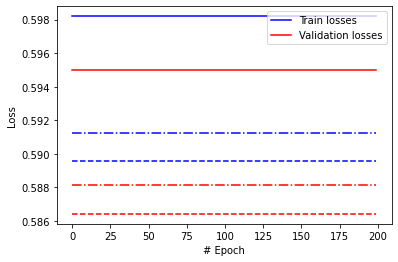

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0
Epoch: 200, Training Loss: 0.59397, Validation loss: 0.59077
Epoch: 200, Training Loss: 0.59570, Validation loss: 0.59264
Epoch: 200, Training Loss: 0.59615, Validation loss: 0.59297
3622.0328550338745


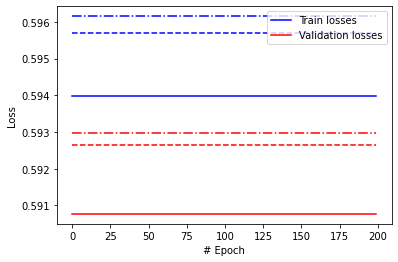

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.5
Epoch: 200, Training Loss: 0.59478, Validation loss: 0.59157
Epoch: 200, Training Loss: 0.59665, Validation loss: 0.59358
Epoch: 200, Training Loss: 0.59465, Validation loss: 0.59135
3663.0913496017456


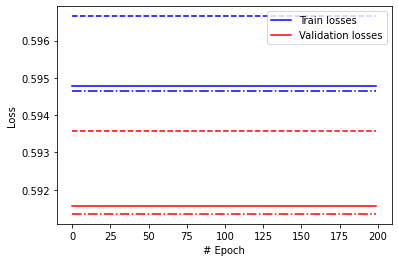

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.9
Epoch: 200, Training Loss: 0.59478, Validation loss: 0.59159
Epoch: 200, Training Loss: 0.59848, Validation loss: 0.59538
Epoch: 200, Training Loss: 0.59471, Validation loss: 0.59152
3660.474177122116


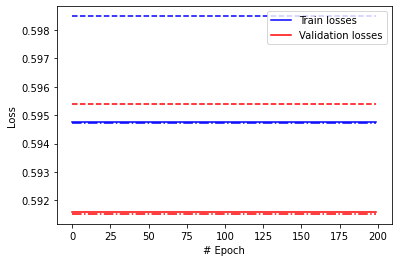

Learning rate:  0.01
Weight decay:  0
Momentum:  0
Epoch: 200, Training Loss: 0.59476, Validation loss: 0.59158
Epoch: 200, Training Loss: 0.60018, Validation loss: 0.59696
Epoch: 200, Training Loss: 0.59454, Validation loss: 0.59130
3625.7592027187347


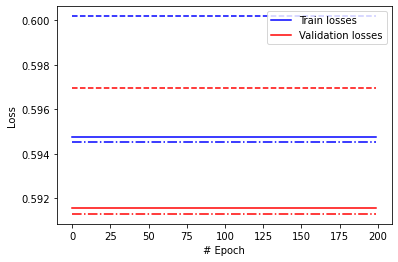

Learning rate:  0.01
Weight decay:  0
Momentum:  0.5
Epoch: 200, Training Loss: 0.59568, Validation loss: 0.59252
Epoch: 200, Training Loss: 0.59932, Validation loss: 0.59608
Epoch: 200, Training Loss: 0.59092, Validation loss: 0.58785
3661.061763525009


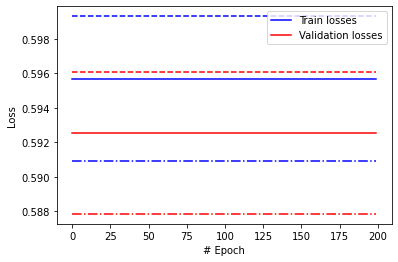

Learning rate:  0.01
Weight decay:  0
Momentum:  0.9
Epoch: 200, Training Loss: 0.59708, Validation loss: 0.59396
Epoch: 200, Training Loss: 0.59015, Validation loss: 0.58703
Epoch: 200, Training Loss: 0.59189, Validation loss: 0.58887
3975.6115684509277


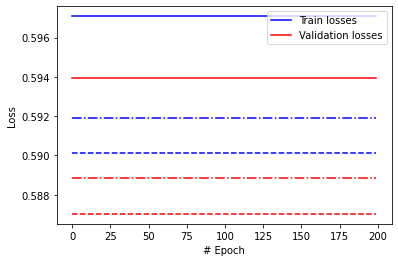

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0
Epoch: 200, Training Loss: 0.59485, Validation loss: 0.59166
Epoch: 200, Training Loss: 0.59891, Validation loss: 0.59577
Epoch: 200, Training Loss: 0.59461, Validation loss: 0.59149
4541.86851811409


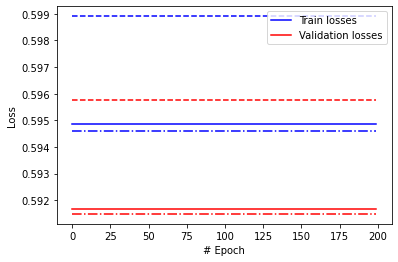

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.5
Epoch: 200, Training Loss: 0.59759, Validation loss: 0.59445
Epoch: 200, Training Loss: 0.59326, Validation loss: 0.59019
Epoch: 200, Training Loss: 0.59266, Validation loss: 0.58953
4576.4713797569275


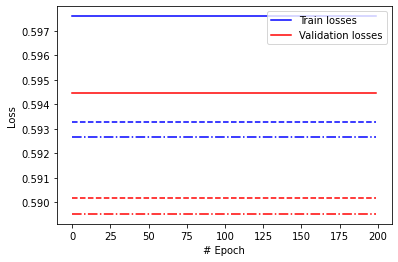

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.9
Epoch: 200, Training Loss: 0.58920, Validation loss: 0.58591
Epoch: 200, Training Loss: 0.59732, Validation loss: 0.59417
Epoch: 200, Training Loss: 0.59161, Validation loss: 0.58836
4582.469655990601


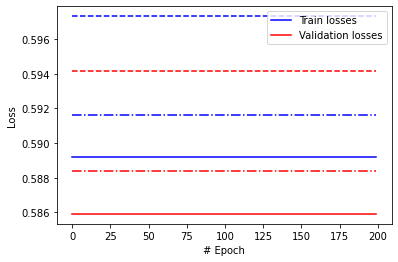

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0
Epoch: 200, Training Loss: 0.59570, Validation loss: 0.59248
Epoch: 200, Training Loss: 0.59432, Validation loss: 0.59118
Epoch: 200, Training Loss: 0.59334, Validation loss: 0.59022
4559.432000398636


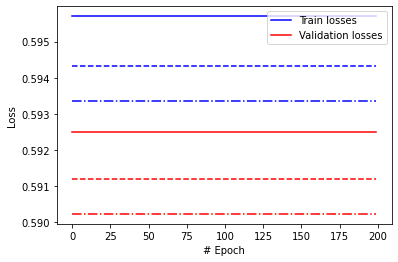

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.5
Epoch: 200, Training Loss: 0.59382, Validation loss: 0.59069
Epoch: 200, Training Loss: 0.59242, Validation loss: 0.58924
Epoch: 200, Training Loss: 0.59984, Validation loss: 0.59666
4582.766947984695


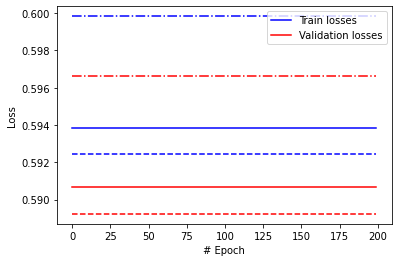

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.9
Epoch: 200, Training Loss: 0.59306, Validation loss: 0.58996
Epoch: 200, Training Loss: 0.59652, Validation loss: 0.59341
Epoch: 200, Training Loss: 0.59539, Validation loss: 0.59228
4580.5890192985535


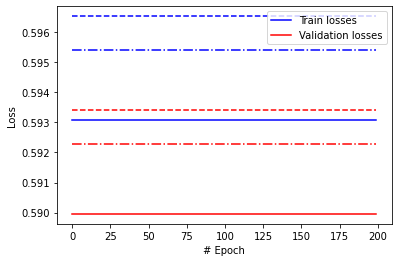

ADAM optimizer:
Learning rate:  0.1
Weight decay:  0
Epoch: 200, Training Loss: 0.60905, Validation loss: 0.60572
Epoch: 200, Training Loss: 0.60905, Validation loss: 0.60572
Epoch: 200, Training Loss: 0.60905, Validation loss: 0.60572
5007.374815702438


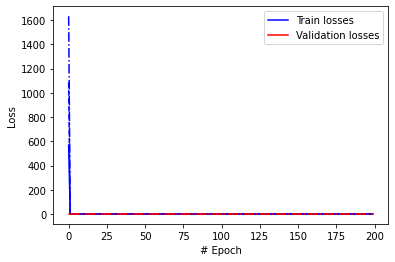

Learning rate:  0.1
Weight decay:  0.0001
Epoch: 200, Training Loss: 33.52909, Validation loss: 0.60572
Epoch: 200, Training Loss: 0.60905, Validation loss: 0.60572
Epoch: 200, Training Loss: 0.58577, Validation loss: 0.58034
5069.629283428192


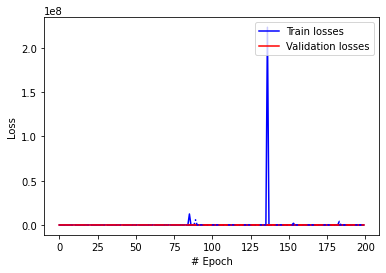

Learning rate:  0.1
Weight decay:  0.001
Epoch: 200, Training Loss: 0.60905, Validation loss: 0.60572
Epoch: 200, Training Loss: 0.60905, Validation loss: 0.60572
Epoch: 200, Training Loss: 0.60905, Validation loss: 0.60572
4297.878522157669


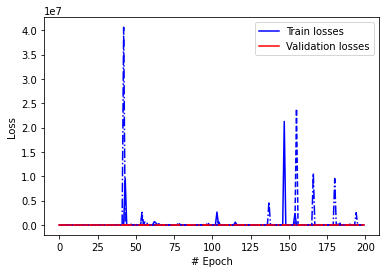

Learning rate:  0.01
Weight decay:  0
Epoch: 200, Training Loss: 0.30324, Validation loss: 0.31413
Epoch: 200, Training Loss: 0.30317, Validation loss: 0.31536
Epoch: 200, Training Loss: 0.30335, Validation loss: 0.31484
4139.07372879982


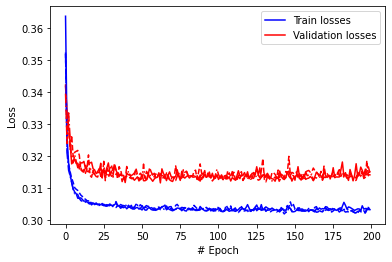

Learning rate:  0.01
Weight decay:  0.0001
Epoch: 200, Training Loss: 0.31899, Validation loss: 0.32652
Epoch: 200, Training Loss: 0.31823, Validation loss: 0.32538


In [ ]:
lrs = [0.1, 0.01]
wds = [0, 0.0001, 0.001]
ms = [0, 0.5, 0.9]

print("15 minute runs")
node_feat = torch.load('input_15m_2017.pt')
glob_feat = torch.load('calendar_2017_15m_features.pt')
response = torch.load('response_15m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_15m_2017.pt')
valid_mask = torch.load('valid_mask_15m_2017.pt')
test_mask = torch.load('test_mask_15m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 3

print("SGD optimizer:")
for LR in lrs:
    for WD in wds:
        for M in ms:
            optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
            criterion = torch.nn.MSELoss()
            
            train_losses = []
            valid_losses = []

            print("Learning rate: ", LR)
            print("Weight decay: ", WD)
            print("Momentum: ", M)
            t0 = time.time()
            for n in range(n_iter):
                model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
                tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
                train_losses.append(tls)
                valid_losses.append(vls)
            t1 = time.time()
            print(t1-t0)
            
            plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
            plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
            for m in range(1,n_iter):
                plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
                plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.show()
            

lrs = [0.1, 0.01]
wds = [0, 0.0001, 0.001]

print("ADAM optimizer:")
for LR in lrs:
    for WD in wds:
        criterion = torch.nn.MSELoss()

        train_losses = []
        valid_losses = []

        print("Learning rate: ", LR)
        print("Weight decay: ", WD)
        t0 = time.time()
        for n in range(n_iter):
            model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
            tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
            train_losses.append(tls)
            valid_losses.append(vls)
        t1 = time.time()
        print(t1-t0)

        plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
        plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
        for m in range(1,n_iter):
            plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
            plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
        plt.xlabel("# Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.show()


15 minute runs
ADAM optimizer:
Learning rate:  0.01
Weight decay:  0.001
Epoch: 200, Training Loss: 0.34237, Validation loss: 0.34940
Epoch: 200, Training Loss: 0.34151, Validation loss: 0.35187
Epoch: 200, Training Loss: 0.34186, Validation loss: 0.35642
5050.042543411255


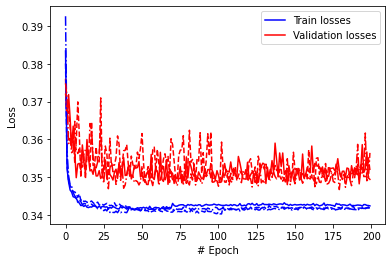

Learning rate:  0.01
Weight decay:  0.0001
Epoch: 200, Training Loss: 0.31952, Validation loss: 0.32877
Epoch: 200, Training Loss: 0.32058, Validation loss: 0.33467
Epoch: 200, Training Loss: 0.31984, Validation loss: 0.33877
4352.650389432907


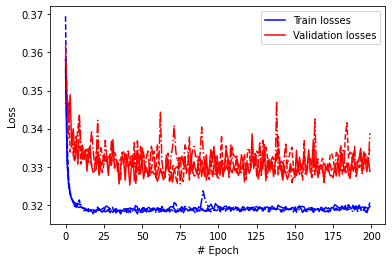

Learning rate:  0.01
Weight decay:  0
Epoch: 200, Training Loss: 0.30406, Validation loss: 0.32037
Epoch: 200, Training Loss: 0.30314, Validation loss: 0.31795
Epoch: 200, Training Loss: 0.30385, Validation loss: 0.31887
4124.308417081833


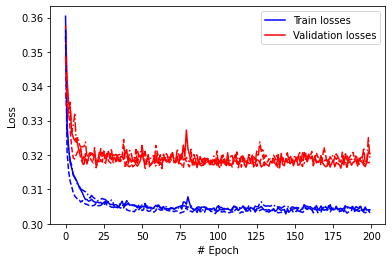

Learning rate:  0.001
Weight decay:  0.001
Epoch: 200, Training Loss: 0.32993, Validation loss: 0.33400
Epoch: 200, Training Loss: 0.33007, Validation loss: 0.33419
Epoch: 200, Training Loss: 0.32951, Validation loss: 0.33362
4179.982722520828


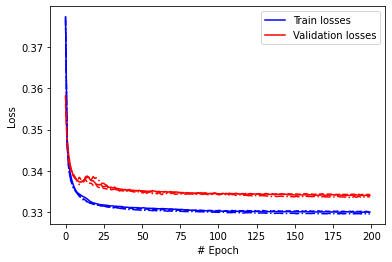

Learning rate:  0.001
Weight decay:  0.0001
Epoch: 200, Training Loss: 0.30293, Validation loss: 0.30941
Epoch: 200, Training Loss: 0.30306, Validation loss: 0.30954
Epoch: 200, Training Loss: 0.30279, Validation loss: 0.30893
4453.644844293594


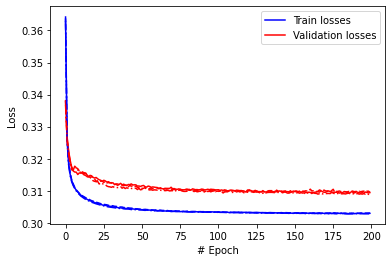

Learning rate:  0.001
Weight decay:  0
Epoch: 200, Training Loss: 0.28416, Validation loss: 0.30705
Epoch: 200, Training Loss: 0.28423, Validation loss: 0.30800
Epoch: 200, Training Loss: 0.28477, Validation loss: 0.30667
4351.386676073074


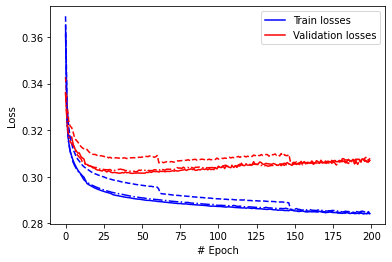

In [10]:
lrs = [0.01, 0.001]
wds = [0.001, 0.0001, 0]

print("15 minute runs")
node_feat = torch.load('input_15m_2017.pt')
glob_feat = torch.load('calendar_2017_15m_features.pt')
response = torch.load('response_15m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_15m_2017.pt')
valid_mask = torch.load('valid_mask_15m_2017.pt')
test_mask = torch.load('test_mask_15m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 3

print("ADAM optimizer:")
for LR in lrs:
    for WD in wds:
        criterion = torch.nn.MSELoss()

        train_losses = []
        valid_losses = []

        print("Learning rate: ", LR)
        print("Weight decay: ", WD)
        t0 = time.time()
        for n in range(n_iter):
            model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
            tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
            train_losses.append(tls)
            valid_losses.append(vls)
        t1 = time.time()
        print(t1-t0)

        plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
        plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
        for m in range(1,n_iter):
            plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
            plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
        plt.xlabel("# Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.show()


## GCN

### 60 minutes

60 minute runs
SGD optimizer:
Learning rate:  0.1
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  1
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  2
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
2270.714535713196


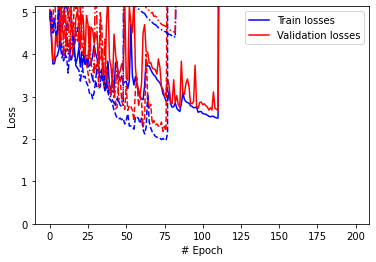

Learning rate:  0.1
Weight decay:  0
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  1
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  2
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
2293.615777015686


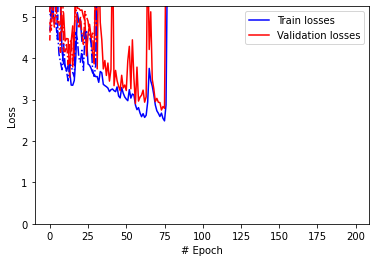

Learning rate:  0.1
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  1
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  2
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
2380.153078556061


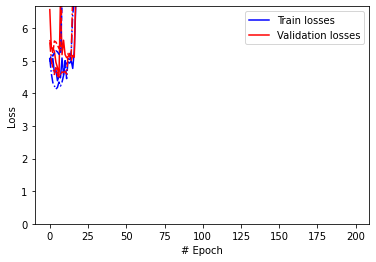

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08921
Iteration:  1
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  2
Epoch: 200, Training Loss: 6.79000, Validation loss: 7.08866
2302.364711999893


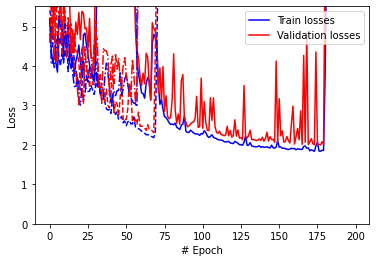

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  1
Epoch: 200, Training Loss: 4.11697, Validation loss: 6.83178
Iteration:  2
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
2294.312535762787


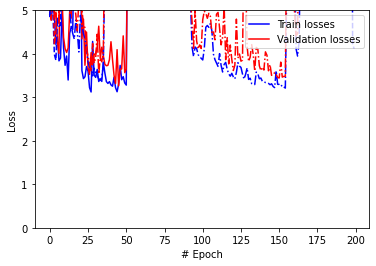

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 5.30838, Validation loss: 5.52504
Iteration:  1
Epoch: 200, Training Loss: 4.39264, Validation loss: 4.63950
Iteration:  2
Epoch: 200, Training Loss: 5.05968, Validation loss: 5.87501
2256.834862947464


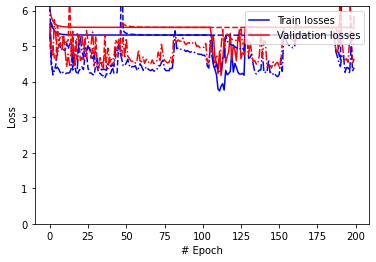

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 5.52750, Validation loss: 5.75456
Iteration:  1
Epoch: 200, Training Loss: 5.47010, Validation loss: 5.69481
Iteration:  2
Epoch: 200, Training Loss: 4.09560, Validation loss: 4.13075
2260.3423047065735


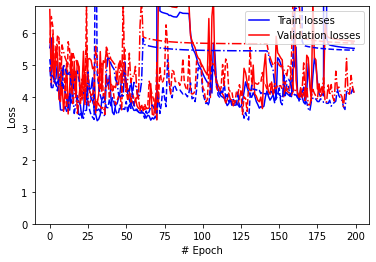

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 5.46912, Validation loss: 5.69311
Iteration:  1
Epoch: 200, Training Loss: 3.96662, Validation loss: 4.90676
Iteration:  2
Epoch: 200, Training Loss: 5.47268, Validation loss: 5.69679
2307.659904241562


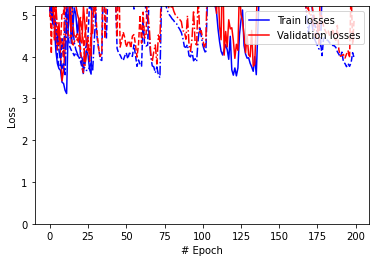

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 5.44957, Validation loss: 5.67735
Iteration:  1
Epoch: 200, Training Loss: 5.67152, Validation loss: 5.90108
Iteration:  2
Epoch: 200, Training Loss: 5.44957, Validation loss: 5.67735
2320.5253319740295


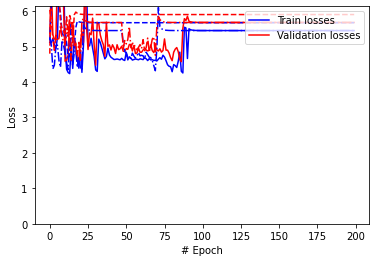

Learning rate:  0.01
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.52836, Validation loss: 1.60595
Iteration:  1
Epoch: 200, Training Loss: 1.59279, Validation loss: 1.69190
Iteration:  2
Epoch: 200, Training Loss: 1.56269, Validation loss: 1.64776
2298.4186437129974


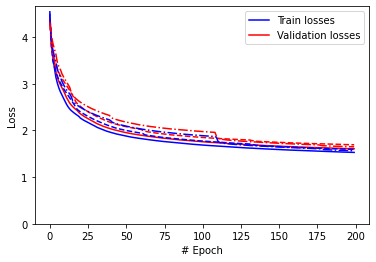

Learning rate:  0.01
Weight decay:  0
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.40874, Validation loss: 1.52144
Iteration:  1
Epoch: 200, Training Loss: 1.40489, Validation loss: 1.52949
Iteration:  2
Epoch: 200, Training Loss: 1.41279, Validation loss: 1.53900
2279.209237575531


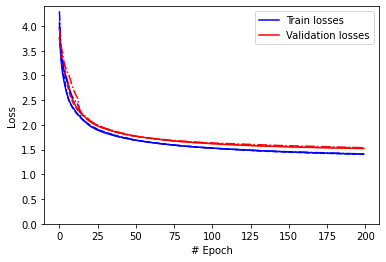

Learning rate:  0.01
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.27031, Validation loss: 1.45488
Iteration:  1
Epoch: 200, Training Loss: 1.27301, Validation loss: 1.52870
Iteration:  2
Epoch: 200, Training Loss: 1.27838, Validation loss: 1.46764
2277.705075740814


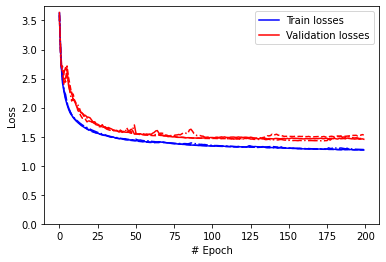

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.53059, Validation loss: 1.61066
Iteration:  1
Epoch: 200, Training Loss: 1.56829, Validation loss: 1.64936
Iteration:  2
Epoch: 200, Training Loss: 1.55762, Validation loss: 1.63832
2284.5103526115417


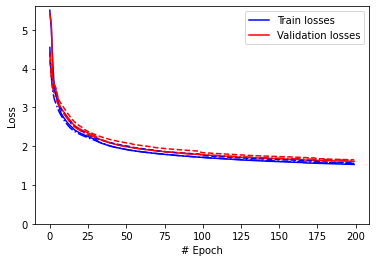

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.42336, Validation loss: 1.54429
Iteration:  1
Epoch: 200, Training Loss: 1.41680, Validation loss: 1.53569
Iteration:  2
Epoch: 200, Training Loss: 1.43001, Validation loss: 1.55308
2289.093019247055


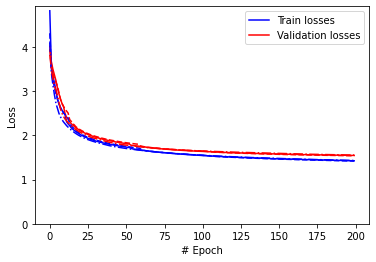

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.29708, Validation loss: 1.51332
Iteration:  1
Epoch: 200, Training Loss: 1.29332, Validation loss: 1.51123
Iteration:  2
Epoch: 200, Training Loss: 1.28458, Validation loss: 1.48042
2295.451320409775


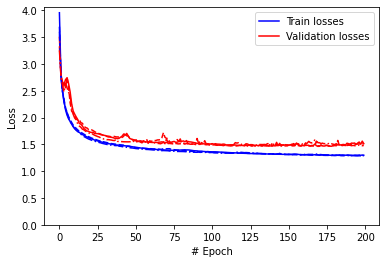

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.57057, Validation loss: 1.64587
Iteration:  1
Epoch: 200, Training Loss: 1.64345, Validation loss: 1.71855
Iteration:  2
Epoch: 200, Training Loss: 1.62312, Validation loss: 1.69613
2263.122598171234


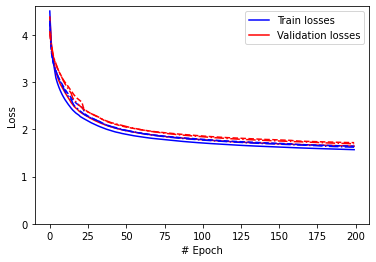

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.48282, Validation loss: 1.56403
Iteration:  1
Epoch: 200, Training Loss: 1.48275, Validation loss: 1.57777
Iteration:  2
Epoch: 200, Training Loss: 1.46933, Validation loss: 1.57669
2257.384556531906


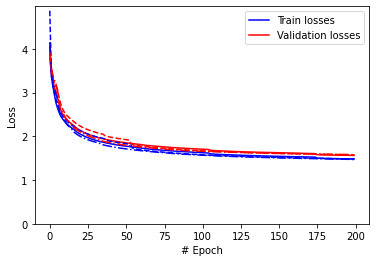

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.43329, Validation loss: 1.59748
Iteration:  1
Epoch: 200, Training Loss: 1.42904, Validation loss: 1.57397
Iteration:  2
Epoch: 200, Training Loss: 1.43304, Validation loss: 1.62880
2282.2789256572723


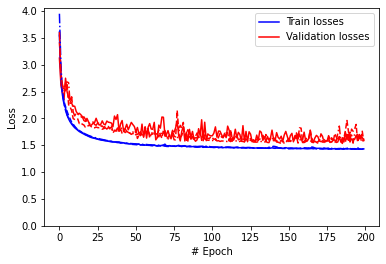

ADAM optimizer:
Learning rate:  0.01
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 1.43963, Validation loss: 1.79031
Iteration:  1
Epoch: 200, Training Loss: 1.46387, Validation loss: 1.80671
Iteration:  2
Epoch: 200, Training Loss: 1.43645, Validation loss: 1.74525
2608.3780698776245


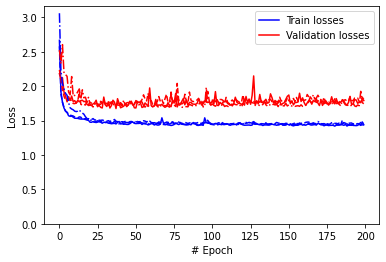

Learning rate:  0.01
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 1.49231, Validation loss: 1.68905
Iteration:  1
Epoch: 200, Training Loss: 1.48942, Validation loss: 1.71554
Iteration:  2
Epoch: 200, Training Loss: 1.49701, Validation loss: 1.67786
2633.58038854599


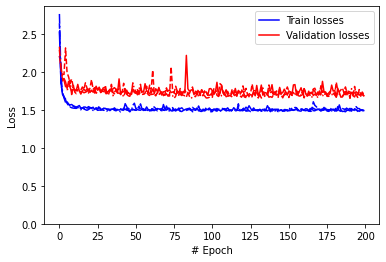

Learning rate:  0.01
Weight decay:  0.001
Iteration:  0
Epoch: 200, Training Loss: 1.70538, Validation loss: 1.93116
Iteration:  1
Epoch: 200, Training Loss: 1.70586, Validation loss: 1.87025
Iteration:  2
Epoch: 200, Training Loss: 1.70809, Validation loss: 1.92777
2613.5966963768005


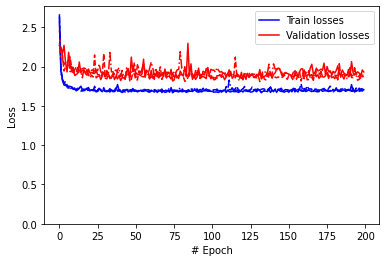

Learning rate:  0.1
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  1
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
Iteration:  2
Epoch: 200, Training Loss: 6.79007, Validation loss: 7.08881
2602.582046985626


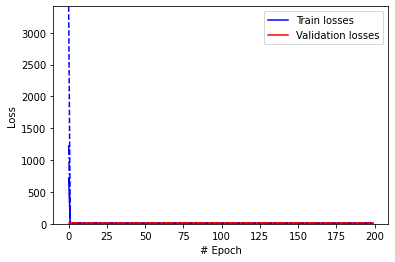

Learning rate:  0.1
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 6.09012, Validation loss: 6.36380
Iteration:  1
Epoch: 200, Training Loss: 6.79025, Validation loss: 7.08881
Iteration:  2
Epoch: 200, Training Loss: 6.74817, Validation loss: 7.04027
2625.470623254776


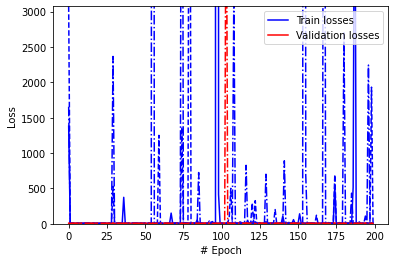

Learning rate:  0.1
Weight decay:  0.001
Iteration:  0
Epoch: 200, Training Loss: 10.30921, Validation loss: 7.05617
Iteration:  1
Epoch: 200, Training Loss: 6.79013, Validation loss: 7.08881
Iteration:  2
Epoch: 200, Training Loss: 6.71356, Validation loss: 7.02827
2617.878900527954


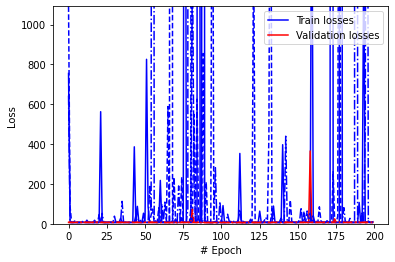

In [26]:
lrs = [0.1, 0.01]
wds = [0, 0.0001, 0.001]
ms = [0, 0.5, 0.9]

print("60 minute runs")
node_feat = torch.load('input_60m_2017.pt')
glob_feat = torch.load('calendar_2017_60m_features.pt')
response = torch.load('response_60m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_60m_2017.pt')
valid_mask = torch.load('valid_mask_60m_2017.pt')
test_mask = torch.load('test_mask_60m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 3

print("SGD optimizer:")
for LR in lrs:
    for WD in wds:
        for M in ms:
            criterion = torch.nn.MSELoss()
            
            train_losses = []
            valid_losses = []

            print("Learning rate: ", LR)
            print("Weight decay: ", WD)
            print("Momentum: ", M)
            t0 = time.time()
            for n in range(n_iter):
                print("Iteration: ", n)
                model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
                optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
                tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
                train_losses.append(tls)
                valid_losses.append(vls)
            t1 = time.time()
            print(t1-t0)

            plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
            plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
            for m in range(1,n_iter):
                plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
                plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
            plt.show()


lrs = [0.01, 0.1]
wds = [0, 0.0001, 0.001]
ms = [0, 0.5, 0.9]
            
print("ADAM optimizer:")
for LR in lrs:
    for WD in wds:
        criterion = torch.nn.MSELoss()

        train_losses = []
        valid_losses = []

        print("Learning rate: ", LR)
        print("Weight decay: ", WD)
        t0 = time.time()
        for n in range(n_iter):
            print("Iteration: ", n)
            model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
            tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
            train_losses.append(tls)
            valid_losses.append(vls)
        t1 = time.time()
        print(t1-t0)

        plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
        plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
        for m in range(1,n_iter):
            plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
            plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
        plt.xlabel("# Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
        plt.show()


### 30 minutes

30 minute runs
SGD optimizer:
Learning rate:  0.01
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.73572, Validation loss: 0.77988
Iteration:  1
Epoch: 200, Training Loss: 0.74437, Validation loss: 0.78717
Iteration:  2
Epoch: 200, Training Loss: 0.73809, Validation loss: 0.78151
4498.978896141052


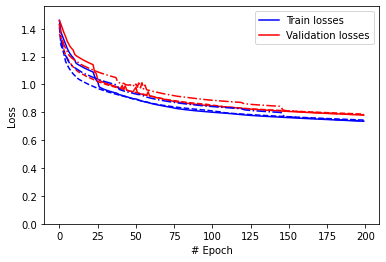

Learning rate:  0.01
Weight decay:  0
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.69029, Validation loss: 0.73974
Iteration:  1
Epoch: 200, Training Loss: 0.68666, Validation loss: 0.73911
Iteration:  2
Epoch: 200, Training Loss: 0.67850, Validation loss: 0.72607
4596.742476701736


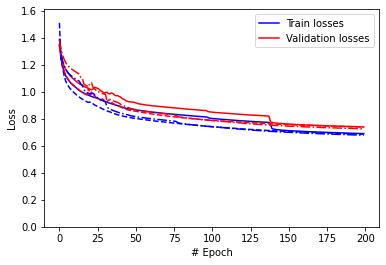

Learning rate:  0.01
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.61457, Validation loss: 0.67602
Iteration:  1
Epoch: 200, Training Loss: 0.61871, Validation loss: 0.67305
Iteration:  2
Epoch: 200, Training Loss: 0.61482, Validation loss: 0.67640
4507.610771656036


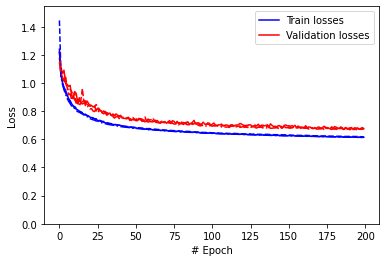

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.73641, Validation loss: 0.77967
Iteration:  1
Epoch: 200, Training Loss: 0.73801, Validation loss: 0.78322
Iteration:  2
Epoch: 200, Training Loss: 0.76208, Validation loss: 0.80718
4545.155413866043


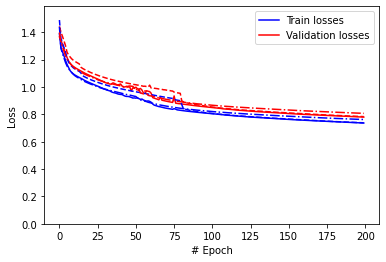

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.69726, Validation loss: 0.74681
Iteration:  1
Epoch: 200, Training Loss: 0.69473, Validation loss: 0.74483
Iteration:  2
Epoch: 200, Training Loss: 0.69212, Validation loss: 0.74231
4750.443557262421


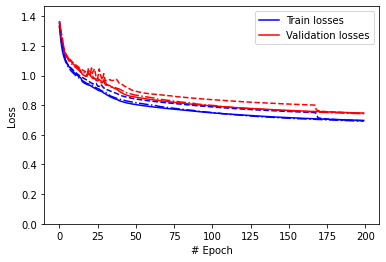

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.62477, Validation loss: 0.68085
Iteration:  1
Epoch: 200, Training Loss: 0.62150, Validation loss: 0.69946
Iteration:  2
Epoch: 200, Training Loss: 0.62741, Validation loss: 0.68416
4559.758748531342


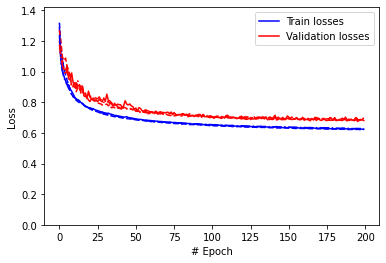

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.76396, Validation loss: 0.80685
Iteration:  1
Epoch: 200, Training Loss: 0.75578, Validation loss: 0.79913
Iteration:  2
Epoch: 200, Training Loss: 0.75461, Validation loss: 0.79812
4546.69361615181


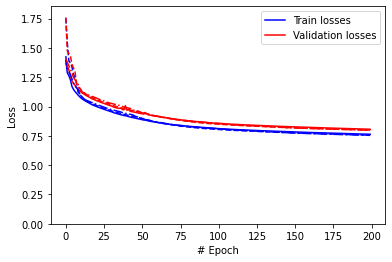

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.71178, Validation loss: 0.76209
Iteration:  1
Epoch: 200, Training Loss: 0.71065, Validation loss: 0.76103
Iteration:  2
Epoch: 200, Training Loss: 0.72023, Validation loss: 0.77108
4807.553232908249


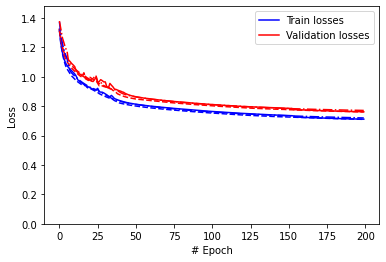

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.69078, Validation loss: 0.75943
Iteration:  1
Epoch: 200, Training Loss: 0.68906, Validation loss: 0.74817
Iteration:  2
Epoch: 200, Training Loss: 0.68677, Validation loss: 0.74925
4833.861888885498


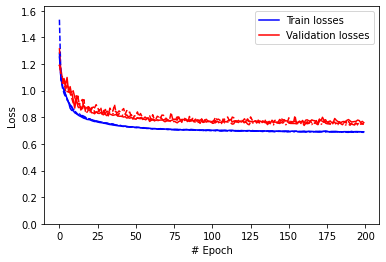

Learning rate:  0.1
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.64301, Validation loss: 0.69294
Iteration:  1
Epoch: 200, Training Loss: 0.65000, Validation loss: 0.69899
Iteration:  2
Epoch: 200, Training Loss: 0.65169, Validation loss: 0.71906
4655.283800601959


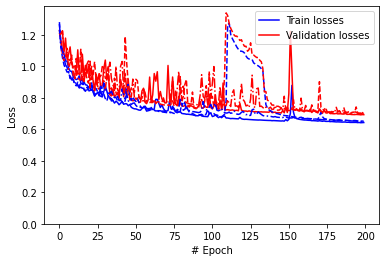

Learning rate:  0.1
Weight decay:  0
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.63435, Validation loss: 0.70819
Iteration:  1
Epoch: 200, Training Loss: 1.23551, Validation loss: 1.29422
Iteration:  2
Epoch: 200, Training Loss: 0.65827, Validation loss: 0.74372
4913.689481019974


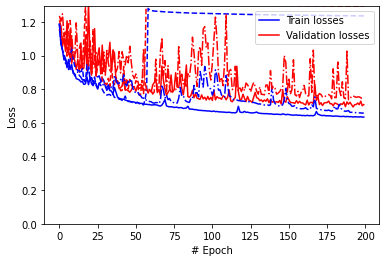

Learning rate:  0.1
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.06500, Validation loss: 1.13287
Iteration:  1
Epoch: 200, Training Loss: 1.23712, Validation loss: 1.30645
Iteration:  2
Epoch: 200, Training Loss: 1.23659, Validation loss: 1.30257
4861.286550045013


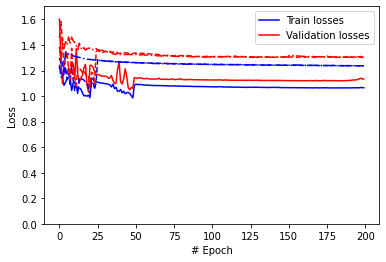

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 1.25283, Validation loss: 1.30913
Iteration:  1
Epoch: 200, Training Loss: 1.25754, Validation loss: 1.31198
Iteration:  2
Epoch: 200, Training Loss: 1.25183, Validation loss: 1.30562
4868.723865509033


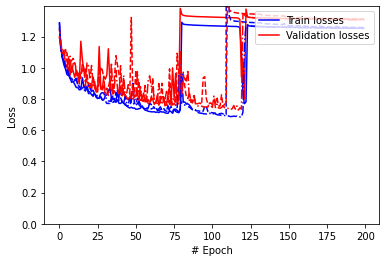

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 1.24486, Validation loss: 1.30426
Iteration:  1
Epoch: 200, Training Loss: 1.24073, Validation loss: 1.29941
Iteration:  2
Epoch: 200, Training Loss: 1.24474, Validation loss: 1.30573
4924.381525039673


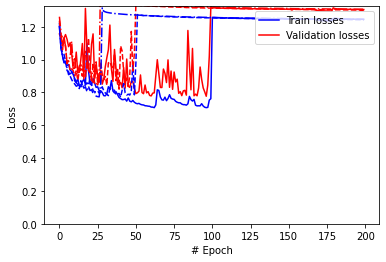

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.33922, Validation loss: 1.43495
Iteration:  1
Epoch: 200, Training Loss: 1.25303, Validation loss: 1.35854
Iteration:  2
Epoch: 200, Training Loss: 1.25915, Validation loss: 1.33974
4974.767488241196


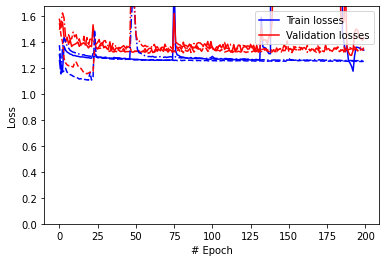

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.82169, Validation loss: 0.91014
Iteration:  1
Epoch: 200, Training Loss: 0.84137, Validation loss: 0.89880
Iteration:  2
Epoch: 200, Training Loss: 0.79600, Validation loss: 0.88701
4900.353569030762


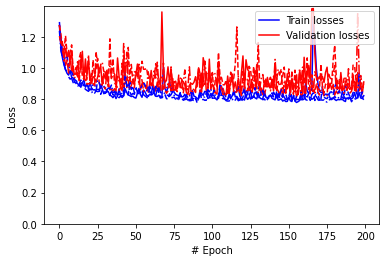

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.86402, Validation loss: 0.90344
Iteration:  1
Epoch: 200, Training Loss: 0.86887, Validation loss: 1.04426
Iteration:  2
Epoch: 200, Training Loss: 0.86670, Validation loss: 1.18018
4978.44581413269


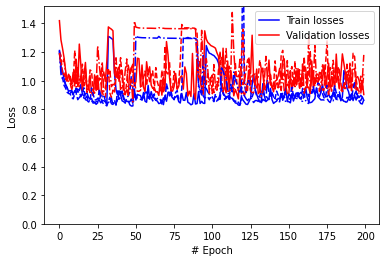

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.51426, Validation loss: 1.57581
Iteration:  1
Epoch: 200, Training Loss: 1.29657, Validation loss: 1.39377
Iteration:  2
Epoch: 200, Training Loss: 1.33708, Validation loss: 1.41968
4900.094061374664


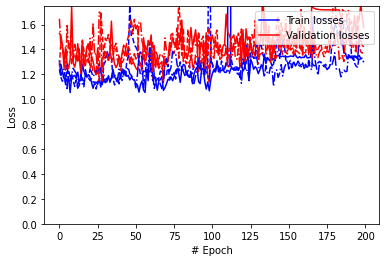

ADAM optimizer:
Learning rate:  0.01
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 0.63711, Validation loss: 0.74545
Iteration:  1
Epoch: 200, Training Loss: 0.61584, Validation loss: 0.70933
Iteration:  2
Epoch: 200, Training Loss: 0.61587, Validation loss: 0.71190
6107.1949009895325


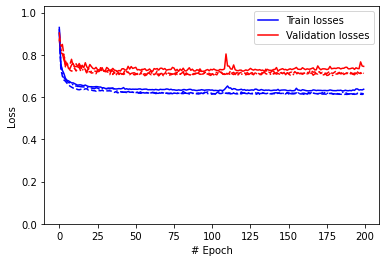

Learning rate:  0.01
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 0.65999, Validation loss: 0.73019
Iteration:  1
Epoch: 200, Training Loss: 0.66256, Validation loss: 0.75177
Iteration:  2
Epoch: 200, Training Loss: 0.66493, Validation loss: 0.75417
6103.687055826187


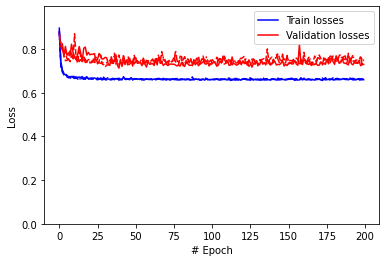

Learning rate:  0.01
Weight decay:  0.001
Iteration:  0
Epoch: 200, Training Loss: 0.73057, Validation loss: 0.79636
Iteration:  1
Epoch: 200, Training Loss: 0.73954, Validation loss: 0.85671
Iteration:  2
Epoch: 200, Training Loss: 0.72864, Validation loss: 0.84406
6101.4206438064575


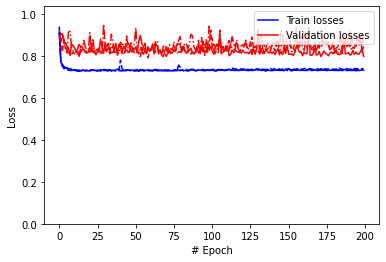

Learning rate:  0.1
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 1.95013, Validation loss: 2.04245
Iteration:  1
Epoch: 200, Training Loss: 1.95013, Validation loss: 2.04245
Iteration:  2
Epoch: 200, Training Loss: 1.95013, Validation loss: 2.04245
6085.343877792358


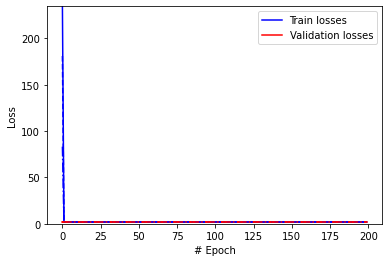

Learning rate:  0.1
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 1.95013, Validation loss: 2.04245
Iteration:  1
Epoch: 200, Training Loss: 2.00475, Validation loss: 2.04245
Iteration:  2
Epoch: 200, Training Loss: 32.37736, Validation loss: 2.04245
6133.369615793228


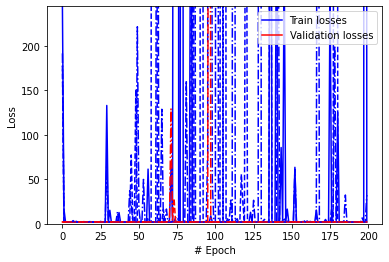

Learning rate:  0.1
Weight decay:  0.001
Iteration:  0
Epoch: 200, Training Loss: 1.95059, Validation loss: 2.04245
Iteration:  1
Epoch: 200, Training Loss: 7.57897, Validation loss: 2.04245
Iteration:  2
Epoch: 200, Training Loss: 1.78973, Validation loss: 1.89034
5158.985137224197


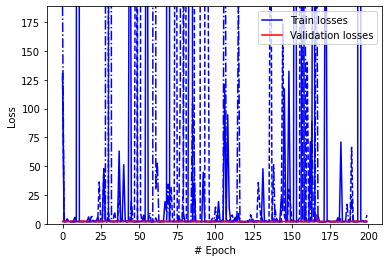

In [27]:
lrs = [0.01, 0.1]
wds = [0, 0.0001, 0.001]
ms = [0, 0.5, 0.9]

print("30 minute runs")
node_feat = torch.load('input_30m_2017.pt')
glob_feat = torch.load('calendar_2017_30m_features.pt')
response = torch.load('response_30m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_30m_2017.pt')
valid_mask = torch.load('valid_mask_30m_2017.pt')
test_mask = torch.load('test_mask_30m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 3

print("SGD optimizer:")
for LR in lrs:
    for WD in wds:
        for M in ms:
            criterion = torch.nn.MSELoss()
            
            train_losses = []
            valid_losses = []

            print("Learning rate: ", LR)
            print("Weight decay: ", WD)
            print("Momentum: ", M)
            t0 = time.time()
            for n in range(n_iter):
                print("Iteration: ", n)
                model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
                optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
                tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
                train_losses.append(tls)
                valid_losses.append(vls)
            t1 = time.time()
            print(t1-t0)

            plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
            plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
            for m in range(1,n_iter):
                plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
                plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
            plt.show()


lrs = [0.01, 0.1]
wds = [0, 0.0001, 0.001]
ms = [0, 0.5, 0.9]

print("ADAM optimizer:")
for LR in lrs:
    for WD in wds:
        criterion = torch.nn.MSELoss()

        train_losses = []
        valid_losses = []

        print("Learning rate: ", LR)
        print("Weight decay: ", WD)
        t0 = time.time()
        for n in range(n_iter):
            print("Iteration: ", n)
            model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
            tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
            train_losses.append(tls)
            valid_losses.append(vls)
        t1 = time.time()
        print(t1-t0)

        plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
        plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
        for m in range(1,n_iter):
            plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
            plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
        plt.xlabel("# Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
        plt.show()


### 15 minutes

15 minute runs
SGD optimizer:
Learning rate:  0.01
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.39001, Validation loss: 0.38458
Iteration:  1
Epoch: 200, Training Loss: 0.39273, Validation loss: 0.38709
Iteration:  2
Epoch: 200, Training Loss: 0.38896, Validation loss: 0.38333
8744.877514600754


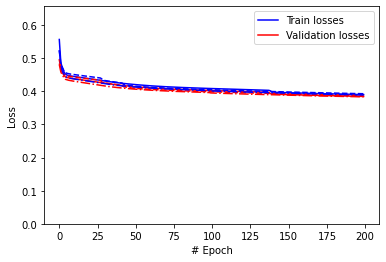

Learning rate:  0.01
Weight decay:  0
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.37502, Validation loss: 0.37021
Iteration:  1
Epoch: 200, Training Loss: 0.37873, Validation loss: 0.37442
Iteration:  2
Epoch: 200, Training Loss: 0.37587, Validation loss: 0.37104
8706.081304073334


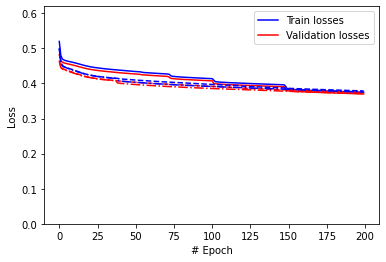

Learning rate:  0.01
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.34785, Validation loss: 0.34701
Iteration:  1
Epoch: 200, Training Loss: 0.34678, Validation loss: 0.34345
Iteration:  2
Epoch: 200, Training Loss: 0.34794, Validation loss: 0.34444
9279.811903238297


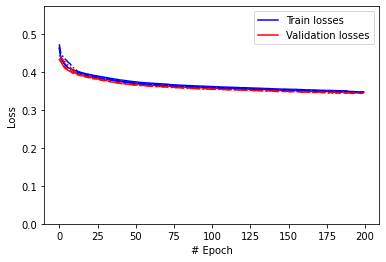

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.39522, Validation loss: 0.38945
Iteration:  1
Epoch: 200, Training Loss: 0.38939, Validation loss: 0.38375
Iteration:  2
Epoch: 200, Training Loss: 0.39231, Validation loss: 0.38660
8764.335215330124


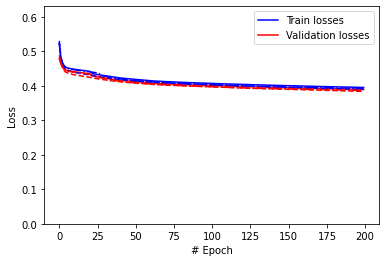

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.37401, Validation loss: 0.36945
Iteration:  1
Epoch: 200, Training Loss: 0.37746, Validation loss: 0.37244
Iteration:  2
Epoch: 200, Training Loss: 0.37531, Validation loss: 0.37102
8705.69491815567


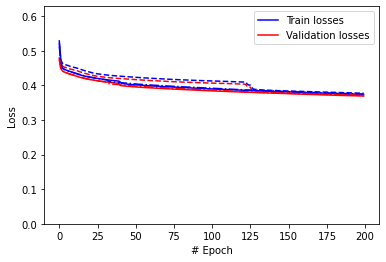

Learning rate:  0.01
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.35113, Validation loss: 0.34787
Iteration:  1
Epoch: 200, Training Loss: 0.35583, Validation loss: 0.35210
Iteration:  2
Epoch: 200, Training Loss: 0.35300, Validation loss: 0.34844
9136.768265724182


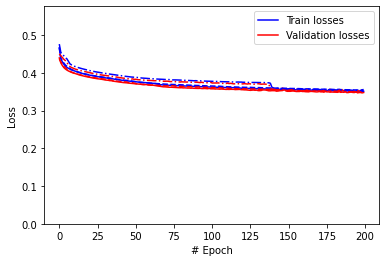

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.39916, Validation loss: 0.39306
Iteration:  1
Epoch: 200, Training Loss: 0.40043, Validation loss: 0.39435
Iteration:  2
Epoch: 200, Training Loss: 0.41137, Validation loss: 0.40501
9024.196850538254


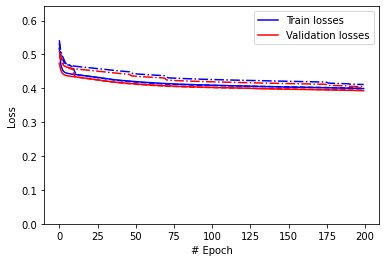

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.38675, Validation loss: 0.38123
Iteration:  1
Epoch: 200, Training Loss: 0.38424, Validation loss: 0.37876
Iteration:  2
Epoch: 200, Training Loss: 0.38921, Validation loss: 0.38352
9026.471984624863


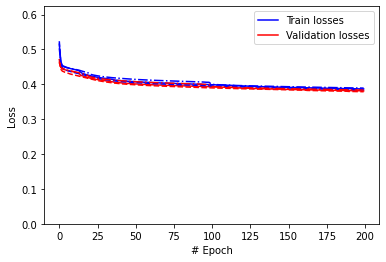

Learning rate:  0.01
Weight decay:  0.001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.37437, Validation loss: 0.36958
Iteration:  1
Epoch: 200, Training Loss: 0.37540, Validation loss: 0.37070
Iteration:  2
Epoch: 200, Training Loss: 0.37458, Validation loss: 0.37011
9303.757945537567


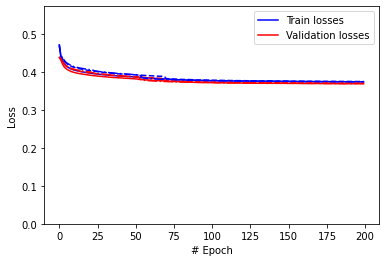

Learning rate:  0.1
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.34921, Validation loss: 0.34713
Iteration:  1
Epoch: 200, Training Loss: 0.34872, Validation loss: 0.34550
Iteration:  2
Epoch: 200, Training Loss: 0.35107, Validation loss: 0.34996
9023.68568778038


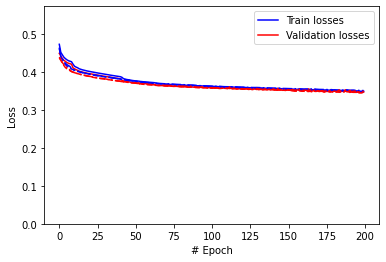

Learning rate:  0.1
Weight decay:  0
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.33889, Validation loss: 0.33807
Iteration:  1
Epoch: 200, Training Loss: 0.34014, Validation loss: 0.33828
Iteration:  2
Epoch: 200, Training Loss: 0.34282, Validation loss: 0.34157
8951.752793073654


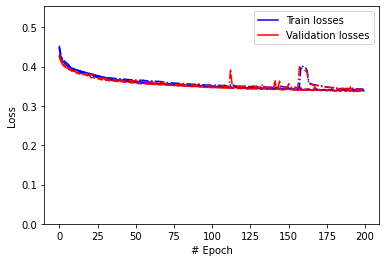

Learning rate:  0.1
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.35877, Validation loss: 0.35329
Iteration:  1
Epoch: 200, Training Loss: 0.34914, Validation loss: 0.34885
Iteration:  2
Epoch: 200, Training Loss: 0.33247, Validation loss: 0.33420
8704.80731678009


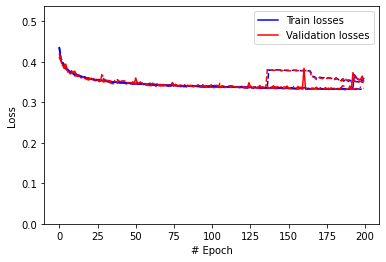

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.35271, Validation loss: 0.34994
Iteration:  1
Epoch: 200, Training Loss: 0.35305, Validation loss: 0.34942
Iteration:  2
Epoch: 200, Training Loss: 0.35104, Validation loss: 0.34745
9094.936626911163


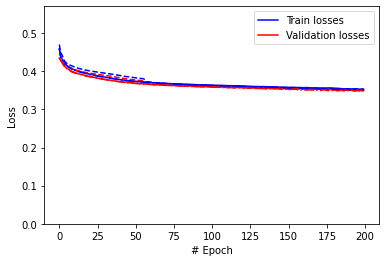

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.34524, Validation loss: 0.34284
Iteration:  1
Epoch: 200, Training Loss: 0.34596, Validation loss: 0.34472
Iteration:  2
Epoch: 200, Training Loss: 0.34439, Validation loss: 0.34431
8731.623654603958


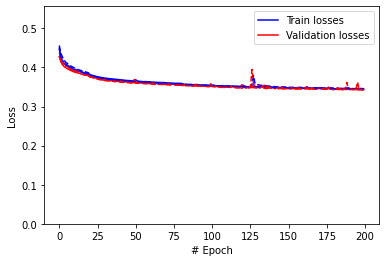

Learning rate:  0.1
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.34624, Validation loss: 0.34738
Iteration:  1
Epoch: 200, Training Loss: 0.34806, Validation loss: 0.34631
Iteration:  2
Epoch: 200, Training Loss: 0.34655, Validation loss: 0.34703
8903.199525356293


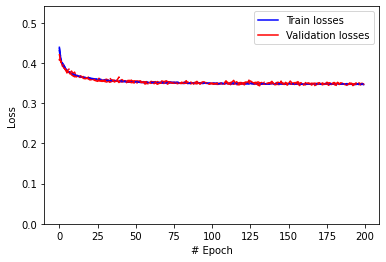

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 200, Training Loss: 0.37448, Validation loss: 0.36962
Iteration:  1
Epoch: 200, Training Loss: 0.37480, Validation loss: 0.36994
Iteration:  2
Epoch: 200, Training Loss: 0.37499, Validation loss: 0.37034
9060.435517787933


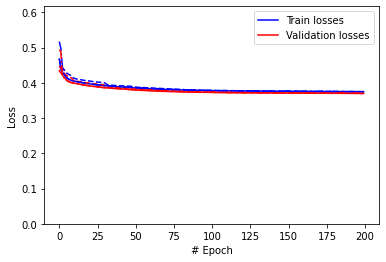

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.5
Iteration:  0
Epoch: 200, Training Loss: 0.37419, Validation loss: 0.37032
Iteration:  1
Epoch: 200, Training Loss: 0.37419, Validation loss: 0.37052
Iteration:  2
Epoch: 200, Training Loss: 0.37424, Validation loss: 0.37086
8852.268043518066


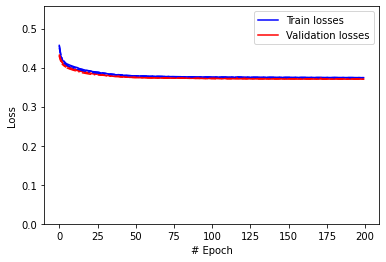

Learning rate:  0.1
Weight decay:  0.001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.38362, Validation loss: 0.38295
Iteration:  1
Epoch: 200, Training Loss: 0.38302, Validation loss: 0.38000
Iteration:  2
Epoch: 200, Training Loss: 0.38263, Validation loss: 0.37776
9027.573690414429


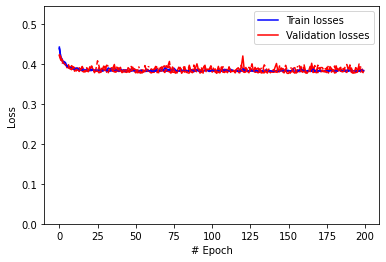

ADAM optimizer:
Learning rate:  0.1
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 0.61191, Validation loss: 0.60044
Iteration:  1
Epoch: 200, Training Loss: 0.61191, Validation loss: 0.60044
Iteration:  2
Epoch: 200, Training Loss: 0.61191, Validation loss: 0.60044
9626.298494815826


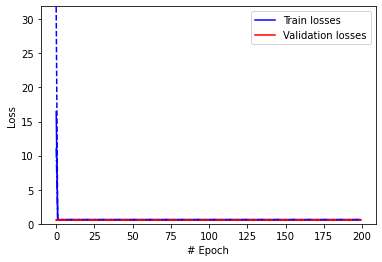

Learning rate:  0.1
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 0.58520, Validation loss: 0.55956
Iteration:  1
Epoch: 200, Training Loss: 0.61191, Validation loss: 0.60044
Iteration:  2
Epoch: 200, Training Loss: 0.61283, Validation loss: 0.60045
9704.316883325577


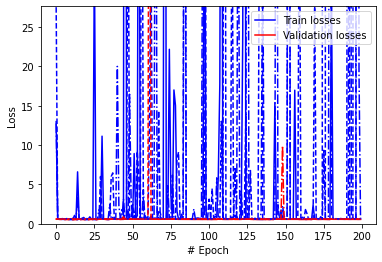

Learning rate:  0.1
Weight decay:  0.001
Iteration:  0
Epoch: 200, Training Loss: 0.61494, Validation loss: 0.60044
Iteration:  1
Epoch: 200, Training Loss: 0.61385, Validation loss: 0.60044
Iteration:  2
Epoch: 200, Training Loss: 0.86481, Validation loss: 0.60044
10973.774552345276


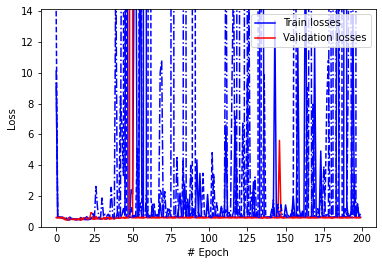

Learning rate:  0.01
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 0.31093, Validation loss: 0.32936
Iteration:  1
Epoch: 200, Training Loss: 0.31039, Validation loss: 0.32755
Iteration:  2
Epoch: 200, Training Loss: 0.31180, Validation loss: 0.32731
11571.149686098099


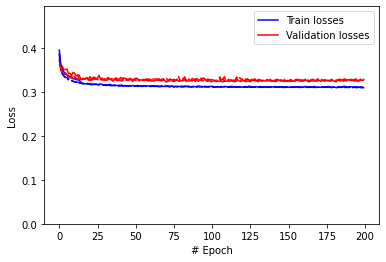

Learning rate:  0.01
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 0.34874, Validation loss: 0.35396
Iteration:  1
Epoch: 200, Training Loss: 0.34867, Validation loss: 0.35374
Iteration:  2
Epoch: 200, Training Loss: 0.34630, Validation loss: 0.35003
11529.375750780106


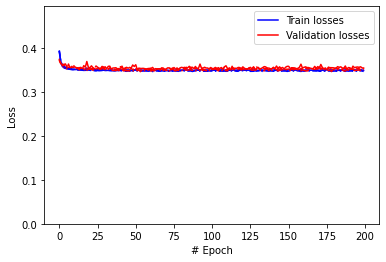

Learning rate:  0.01
Weight decay:  0.001
Iteration:  0
Epoch: 200, Training Loss: 0.38242, Validation loss: 0.38253
Iteration:  1
Epoch: 200, Training Loss: 0.38182, Validation loss: 0.37863
Iteration:  2
Epoch: 200, Training Loss: 0.38093, Validation loss: 0.37824
10974.246157884598


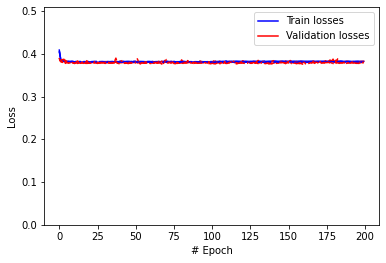

In [28]:
lrs = [0.01, 0.1]
wds = [0, 0.0001, 0.001]
ms = [0, 0.5, 0.9]

print("15 minute runs")
node_feat = torch.load('input_15m_2017.pt')
glob_feat = torch.load('calendar_2017_15m_features.pt')
response = torch.load('response_15m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_15m_2017.pt')
valid_mask = torch.load('valid_mask_15m_2017.pt')
test_mask = torch.load('test_mask_15m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 3

print("SGD optimizer:")
for LR in lrs:
    for WD in wds:
        for M in ms:
            criterion = torch.nn.MSELoss()
            
            train_losses = []
            valid_losses = []

            print("Learning rate: ", LR)
            print("Weight decay: ", WD)
            print("Momentum: ", M)
            t0 = time.time()
            for n in range(n_iter):
                print("Iteration: ", n)
                model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
                optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
                tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
                train_losses.append(tls)
                valid_losses.append(vls)
            t1 = time.time()
            print(t1-t0)

            plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
            plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
            for m in range(1,n_iter):
                plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
                plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
            plt.show()


lrs = [0.1, 0.01]
wds = [0, 0.0001, 0.001]
ms = [0, 0.5, 0.9]

print("ADAM optimizer:")
for LR in lrs:
    for WD in wds:
        criterion = torch.nn.MSELoss()

        train_losses = []
        valid_losses = []

        print("Learning rate: ", LR)
        print("Weight decay: ", WD)
        t0 = time.time()
        for n in range(n_iter):
            print("Iteration: ", n)
            model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
            tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
            train_losses.append(tls)
            valid_losses.append(vls)
        t1 = time.time()
        print(t1-t0)

        plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
        plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
        for m in range(1,n_iter):
            plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
            plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
        plt.xlabel("# Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
        plt.show()


15 minute runs
SGD optimizer:
Learning rate:  0.001
Weight decay:  0
Momentum:  0
Iteration:  0
Epoch: 100, Training Loss: 0.43695, Validation loss: 0.45226
2314.724342107773


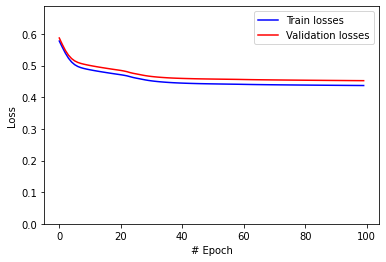

Learning rate:  0.001
Weight decay:  0.0001
Momentum:  0
Iteration:  0
Epoch: 100, Training Loss: 0.44133, Validation loss: 0.45670
2561.5151064395905


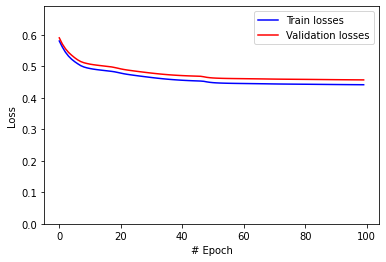

Learning rate:  0.001
Weight decay:  0.001
Momentum:  0
Iteration:  0
Epoch: 100, Training Loss: 0.43879, Validation loss: 0.45416
2375.79842877388


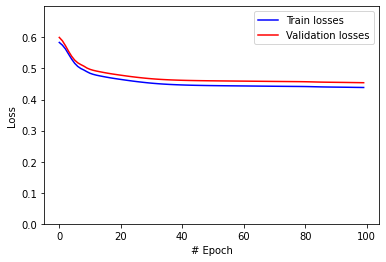

ADAM optimizer:
Learning rate:  0.001
Weight decay:  0
Iteration:  0
Epoch: 100, Training Loss: 0.29473, Validation loss: 0.31849
2362.6747159957886


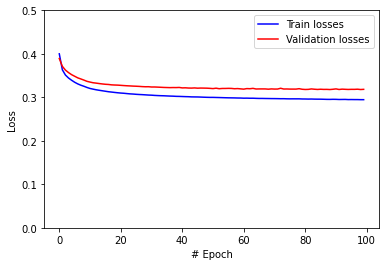

Learning rate:  0.001
Weight decay:  0.0001
Iteration:  0
Epoch: 100, Training Loss: 0.32200, Validation loss: 0.33825
2074.8344917297363


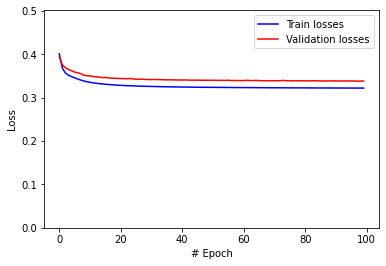

Learning rate:  0.001
Weight decay:  0.001
Iteration:  0
Epoch: 100, Training Loss: 0.36759, Validation loss: 0.38130
2047.4747886657715


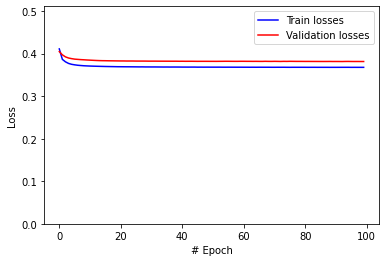

In [11]:
lrs = [0.001]
wds = [0, 0.0001, 0.001]
ms = [0]

print("15 minute runs")
node_feat = torch.load('input_15m_2017.pt')
glob_feat = torch.load('calendar_2017_15m_features.pt')
response = torch.load('response_15m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_15m_2017.pt')
valid_mask = torch.load('valid_mask_15m_2017.pt')
test_mask = torch.load('test_mask_15m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 100

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 1

print("SGD optimizer:")
for LR in lrs:
    for WD in wds:
        for M in ms:
            criterion = torch.nn.MSELoss()
            
            train_losses = []
            valid_losses = []

            print("Learning rate: ", LR)
            print("Weight decay: ", WD)
            print("Momentum: ", M)
            t0 = time.time()
            for n in range(n_iter):
                print("Iteration: ", n)
                model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
                optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
                tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
                train_losses.append(tls)
                valid_losses.append(vls)
            t1 = time.time()
            print(t1-t0)

            plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
            plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
            for m in range(1,n_iter):
                plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
                plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
            plt.show()


lrs = [0.001]
wds = [0, 0.0001, 0.001]

print("ADAM optimizer:")
for LR in lrs:
    for WD in wds:
        criterion = torch.nn.MSELoss()

        train_losses = []
        valid_losses = []

        print("Learning rate: ", LR)
        print("Weight decay: ", WD)
        t0 = time.time()
        for n in range(n_iter):
            print("Iteration: ", n)
            model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
            tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
            train_losses.append(tls)
            valid_losses.append(vls)
        t1 = time.time()
        print(t1-t0)

        plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
        plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
        for m in range(1,n_iter):
            plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
            plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
        plt.xlabel("# Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
        plt.show()


# Final model testing

## 60 minutes

60 minute runs
SGD optimizer:
Learning rate:  0.01
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 1.26075, Validation loss: 1.48879
762.288984298706
Test loss:  1.482469034359568


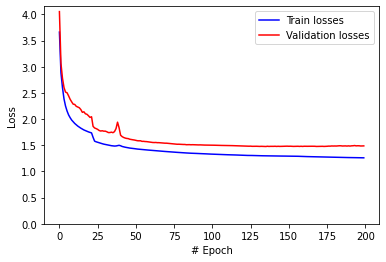

In [32]:
LR = 0.01
WD = 0
M = 0.9

print("60 minute runs")
node_feat = torch.load('input_60m_2017.pt')
glob_feat = torch.load('calendar_2017_60m_features.pt')
response = torch.load('response_60m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_60m_2017.pt')
valid_mask = torch.load('valid_mask_60m_2017.pt')
test_mask = torch.load('test_mask_60m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 1

print("SGD optimizer:")
criterion = torch.nn.MSELoss()

train_losses = []
valid_losses = []

print("Learning rate: ", LR)
print("Weight decay: ", WD)
print("Momentum: ", M)
t0 = time.time()
for n in range(n_iter):
    print("Iteration: ", n)
    model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
    tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
    train_losses.append(tls)
    valid_losses.append(vls)
t1 = time.time()
print(t1-t0)

# Extract data instance
node_data = node_feat[test_mask].float()
glob_data = torch.reshape(
    torch.repeat_interleave(glob_feat[test_mask].float(), node_data.shape[1], dim=0), 
    (node_data.shape[0], node_data.shape[1], -1))

out_test = model(node_data, glob_data, edge_index)

loss_test = criterion(out_test, response[test_mask])
print("Test loss: ", loss_test.item())

plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
for m in range(1,n_iter):
    plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
    plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
plt.show()


60 minute runs
SGD optimizer:
Learning rate:  0.001
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 1.14268, Validation loss: 1.48324
527.0756196975708
Test loss:  1.466122475629394


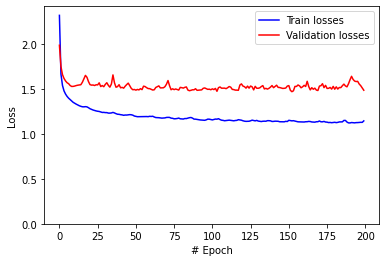

In [28]:
LR = 0.001
WD = 0.0001

print("60 minute runs")
node_feat = torch.load('input_60m_2017.pt')
glob_feat = torch.load('calendar_2017_60m_features.pt')
response = torch.load('response_60m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_60m_2017.pt')
valid_mask = torch.load('valid_mask_60m_2017.pt')
test_mask = torch.load('test_mask_60m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 1

print("SGD optimizer:")
criterion = torch.nn.MSELoss()

train_losses = []
valid_losses = []

print("Learning rate: ", LR)
print("Weight decay: ", WD)

t0 = time.time()
for n in range(n_iter):
    print("Iteration: ", n)
    model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
    train_losses.append(tls)
    valid_losses.append(vls)
t1 = time.time()
print(t1-t0)

# Extract data instance
node_data = node_feat[test_mask].float()
glob_data = torch.reshape(
    torch.repeat_interleave(glob_feat[test_mask].float(), node_data.shape[1], dim=0), 
    (node_data.shape[0], node_data.shape[1], -1))

out_test = model(node_data, glob_data, edge_index)

loss_test = criterion(out_test, response[test_mask])
print("Test loss: ", loss_test.item())

plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
for m in range(1,n_iter):
    plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
    plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
plt.show()


## 30 minutes

30 minute runs
SGD optimizer:
Learning rate:  0.01
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.62089, Validation loss: 0.62556
2135.5451333522797
Test loss:  0.6489126457165795


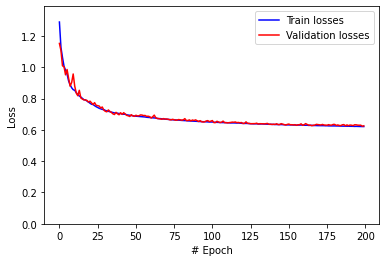

In [23]:
LR = 0.01
WD = 0
M = 0.9

print("30 minute runs")
node_feat = torch.load('input_30m_2017.pt')
glob_feat = torch.load('calendar_2017_30m_features.pt')
response = torch.load('response_30m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_30m_2017.pt')
valid_mask = torch.load('valid_mask_30m_2017.pt')
test_mask = torch.load('test_mask_30m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 1

print("SGD optimizer:")
criterion = torch.nn.MSELoss()

train_losses = []
valid_losses = []

print("Learning rate: ", LR)
print("Weight decay: ", WD)
print("Momentum: ", M)
t0 = time.time()
for n in range(n_iter):
    print("Iteration: ", n)
    model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
    tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
    train_losses.append(tls)
    valid_losses.append(vls)
t1 = time.time()
print(t1-t0)

# Extract data instance
node_data = node_feat[test_mask].float()
glob_data = torch.reshape(
    torch.repeat_interleave(glob_feat[test_mask].float(), node_data.shape[1], dim=0), 
    (node_data.shape[0], node_data.shape[1], -1))

out_test = model(node_data, glob_data, edge_index)

loss_test = criterion(out_test, response[test_mask])
print("Test loss: ", loss_test.item())

plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
for m in range(1,n_iter):
    plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
    plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
plt.show()


30 minute runs
SGD optimizer:
Learning rate:  0.001
Weight decay:  0.0001
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.53952, Validation loss: 0.56565
888.6760449409485
Test loss:  0.5821640093167456


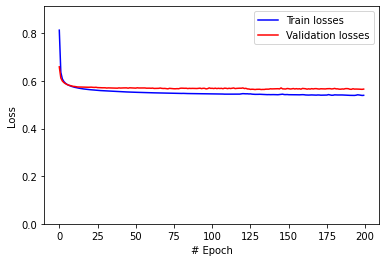

In [29]:
LR = 0.001
WD = 0.0001

print("30 minute runs")
node_feat = torch.load('input_30m_2017.pt')
glob_feat = torch.load('calendar_2017_30m_features.pt')
response = torch.load('response_30m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_30m_2017.pt')
valid_mask = torch.load('valid_mask_30m_2017.pt')
test_mask = torch.load('test_mask_30m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 1

print("SGD optimizer:")
criterion = torch.nn.MSELoss()

train_losses = []
valid_losses = []

print("Learning rate: ", LR)
print("Weight decay: ", WD)
print("Momentum: ", M)
t0 = time.time()
for n in range(n_iter):
    print("Iteration: ", n)
    model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
    train_losses.append(tls)
    valid_losses.append(vls)
t1 = time.time()
print(t1-t0)

# Extract data instance
node_data = node_feat[test_mask].float()
glob_data = torch.reshape(
    torch.repeat_interleave(glob_feat[test_mask].float(), node_data.shape[1], dim=0), 
    (node_data.shape[0], node_data.shape[1], -1))

out_test = model(node_data, glob_data, edge_index)

loss_test = criterion(out_test, response[test_mask])
print("Test loss: ", loss_test.item())

plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
for m in range(1,n_iter):
    plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
    plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
plt.show()


## 15 minutes

15 minute runs
SGD optimizer:
Learning rate:  0.01
Weight decay:  0
Momentum:  0.9
Iteration:  0
Epoch: 200, Training Loss: 0.34886, Validation loss: 0.35534
3345.6608452796936
Test loss:  0.3493561896148566


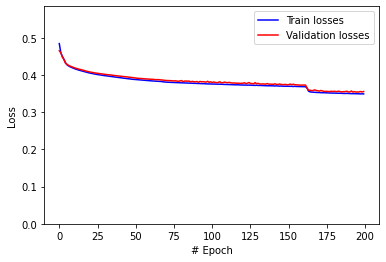

ADAM optimizer:
Learning rate:  0.01
Weight decay:  0
Iteration:  0
Epoch: 200, Training Loss: 0.31014, Validation loss: 0.33492
4143.611857652664
Test loss:  0.3287092981563965


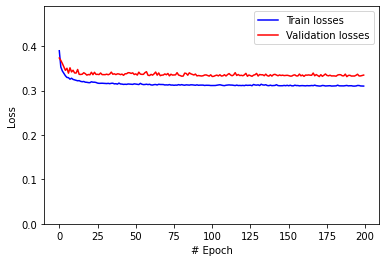

In [24]:
LR = 0.01
WD = 0
M = 0.9

print("15 minute runs")
node_feat = torch.load('input_15m_2017.pt')
glob_feat = torch.load('calendar_2017_15m_features.pt')
response = torch.load('response_15m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_15m_2017.pt')
valid_mask = torch.load('valid_mask_15m_2017.pt')
test_mask = torch.load('test_mask_15m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 1

print("SGD optimizer:")
criterion = torch.nn.MSELoss()

train_losses = []
valid_losses = []

print("Learning rate: ", LR)
print("Weight decay: ", WD)
print("Momentum: ", M)
t0 = time.time()
for n in range(n_iter):
    print("Iteration: ", n)
    model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=M)
    tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
    train_losses.append(tls)
    valid_losses.append(vls)
t1 = time.time()
print(t1-t0)

# Extract data instance
node_data = node_feat[test_mask].float()
glob_data = torch.reshape(
    torch.repeat_interleave(glob_feat[test_mask].float(), node_data.shape[1], dim=0), 
    (node_data.shape[0], node_data.shape[1], -1))

out_test = model(node_data, glob_data, edge_index)

loss_test = criterion(out_test, response[test_mask])
print("Test loss: ", loss_test.item())

plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
for m in range(1,n_iter):
    plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
    plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
plt.show()


LR = 0.01
WD = 0

print("ADAM optimizer:")
criterion = torch.nn.MSELoss()

train_losses = []
valid_losses = []

print("Learning rate: ", LR)
print("Weight decay: ", WD)
t0 = time.time()
for n in range(n_iter):
    print("Iteration: ", n)
    model = Net(node_feat, response, glob_feat, response.shape[2]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
    train_losses.append(tls)
    valid_losses.append(vls)
t1 = time.time()
print(t1-t0)

# Extract data instance
node_data = node_feat[test_mask].float()
glob_data = torch.reshape(
    torch.repeat_interleave(glob_feat[test_mask].float(), node_data.shape[1], dim=0), 
    (node_data.shape[0], node_data.shape[1], -1))

out_test = model(node_data, glob_data, edge_index)

loss_test = criterion(out_test, response[test_mask])
print("Test loss: ", loss_test.item())

plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
for m in range(1,n_iter):
    plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
    plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
plt.show()


15 minute runs
ADAM optimizer:
Learning rate:  0.001
Weight decay:  0.0001
Iteration:  0
Epoch: 200, Training Loss: 0.30400, Validation loss: 0.31261
1763.6459062099457
Test loss:  0.3051194433959087


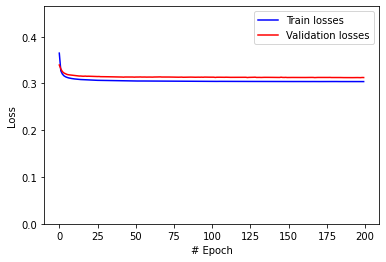

In [27]:
LR = 0.001
WD = 0.0001

print("15 minute runs")
node_feat = torch.load('input_15m_2017.pt')
glob_feat = torch.load('calendar_2017_15m_features.pt')
response = torch.load('response_15m_2017.pt')

n_node_features = node_feat.shape[1]
node_feat = torch.reshape(node_feat, (-1,84,n_node_features))
response = torch.reshape(response, (-1,84,84))

# means = node_feat.mean(dim=1, keepdim=True)
# stds = node_feat.std(dim=1, keepdim=True)
# node_feat = (node_feat - means)/stds

train_mask = torch.load('train_mask_15m_2017.pt')
valid_mask = torch.load('valid_mask_15m_2017.pt')
test_mask = torch.load('test_mask_15m_2017.pt')

batch_size = glob_feat.shape[1] - 8
num_epochs = 200

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)

node_feat = node_feat.to(device)
glob_feat = glob_feat.to(device)
response = response.to(device)

edge_index = graph.edges.to(device)

ls = ['-','--','-.',':',(0, (5,1))]

n_iter = 1

print("ADAM optimizer:")
criterion = torch.nn.MSELoss()

train_losses = []
valid_losses = []

print("Learning rate: ", LR)
print("Weight decay: ", WD)
t0 = time.time()
for n in range(n_iter):
    print("Iteration: ", n)
    model = Net_FC(node_feat, response, glob_feat, response.shape[2]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    tls, vls, nbt, nbv = train(node_feat, response, glob_feat, train_mask, valid_mask, test_mask, edge_index, model, optimizer, criterion, batch_size, num_epochs, plot=False)
    train_losses.append(tls)
    valid_losses.append(vls)
t1 = time.time()
print(t1-t0)

# Extract data instance
node_data = node_feat[test_mask].float()
glob_data = torch.reshape(
    torch.repeat_interleave(glob_feat[test_mask].float(), node_data.shape[1], dim=0), 
    (node_data.shape[0], node_data.shape[1], -1))

out_test = model(node_data, glob_data, edge_index)

loss_test = criterion(out_test, response[test_mask])
print("Test loss: ", loss_test.item())

plt.plot([tl/nbt for tl in train_losses[0]], color='b', label="Train losses")
plt.plot([vl/nbv for vl in valid_losses[0]], color='r', label="Validation losses")
for m in range(1,n_iter):
    plt.plot([tl/nbt for tl in train_losses[m]], color='b', linestyle=ls[m])
    plt.plot([vl/nbv for vl in valid_losses[m]], color='r', linestyle=ls[m])
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.ylim((0,max(max([[tls[0]/nbt for tls in train_losses], [vls[0]/nbv for vls in valid_losses]]))+0.1))
plt.show()


# Check output

In [33]:
model

Net(
  (conv1): GCNConv(
    (lin): Linear(in_features=593, out_features=128, bias=True)
  )
  (conv2): GCNConv(
    (lin): Linear(in_features=128, out_features=84, bias=True)
  )
  (l_out): Linear(in_features=116, out_features=84, bias=True)
)

430
0.7884349822998047
0.0 25.0


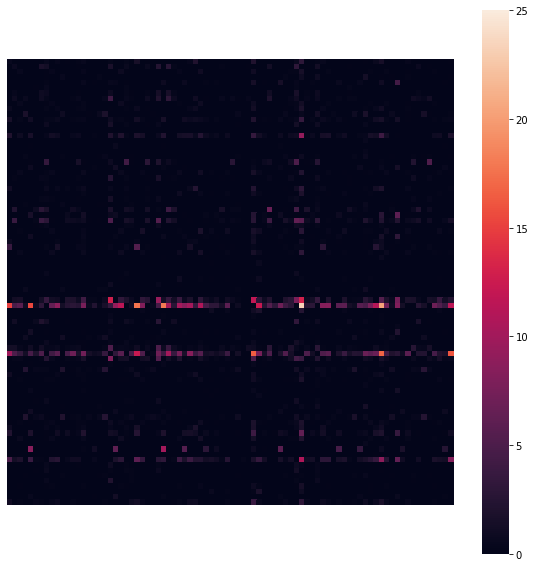

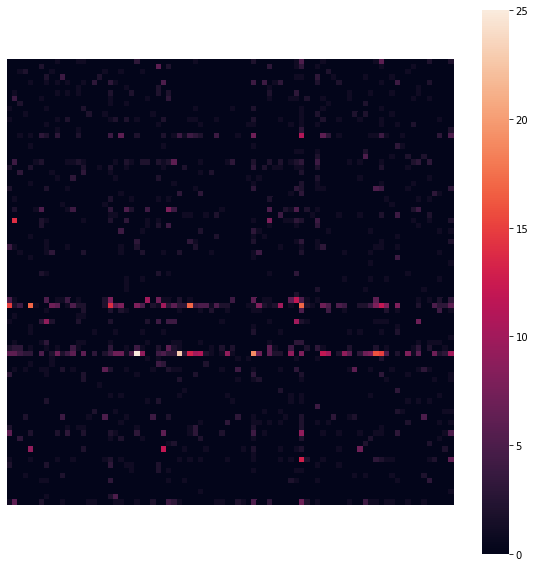

In [69]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

node_feat_test = node_feat[test_mask]
glob_feat_test = glob_feat[test_mask]
response_test = response[test_mask]

r = random.randint(0,node_feat_test.shape[0])
print(r)
node_data = node_feat_test[r][None].float()
glob_data = torch.reshape(
    torch.repeat_interleave(glob_feat_test[r][None].float(), node_data.shape[1], dim=0), 
    (1, node_data.shape[1], -1))

y_data = response_test[r][None].float()

out = model(node_data, glob_data, edge_index)

loss = criterion(out, y_data)
print(loss.item())
vmax = max(torch.max(out).item(),torch.max(y_data).item())
vmin = min(torch.min(out).item(),torch.min(y_data).item())
print(vmin, vmax)

fig, ax1 = plt.subplots(figsize=(10,10))
sns.heatmap(out.detach()[0], vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, square=True, robust=False, ax=ax1)
plt.show()

fig, ax2 = plt.subplots(figsize=(10,10))
sns.heatmap(y_data[0], vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, square=True, robust=False, ax=ax2)
plt.show()


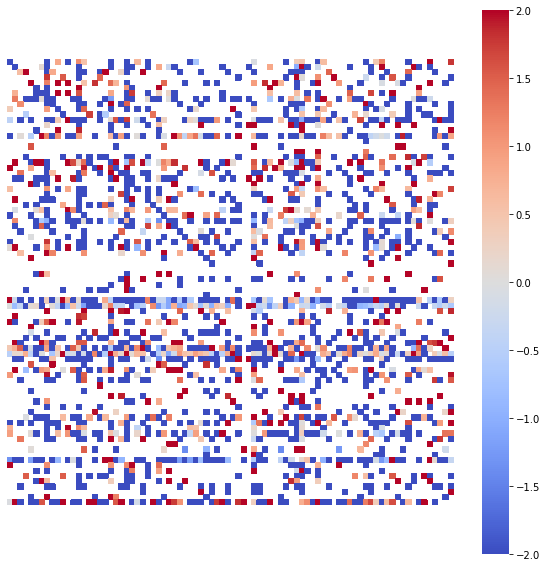

In [96]:
fig, ax3 = plt.subplots(figsize=(10,10))
sns.heatmap(2*torch.div(y_data[0]-out.detach()[0],torch.abs(out.detach()[0])+torch.abs(y_data[0])), cmap='coolwarm', center=0.0, xticklabels=False, yticklabels=False, square=True, robust=False, ax=ax3)
plt.show()


In [81]:
test_mask.nonzero()[430] % 24

tensor([22])

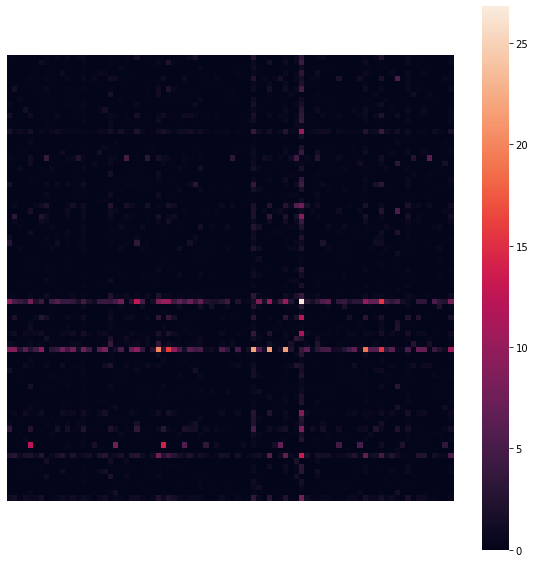

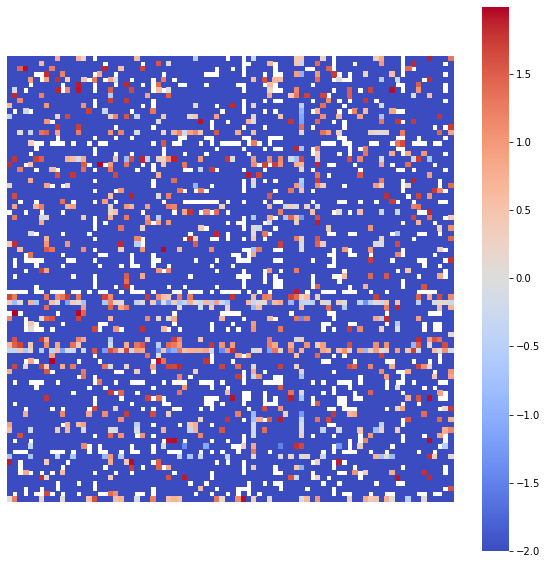

In [97]:
response = torch.load('response_60m_2017.pt')
test_mask = torch.load('test_mask_60m_2017.pt')
ha = torch.mean(response.reshape((-1,24,84,84)), axis=0)#.reshape((-1,84,84))[test_mask]

fig, ax3 = plt.subplots(figsize=(10,10))
sns.heatmap(ha[22], xticklabels=False, yticklabels=False, square=True, robust=False, ax=ax3)
plt.show()

fig, ax3 = plt.subplots(figsize=(10,10))
sns.heatmap(2*torch.div(y_data[0]-ha[22],torch.abs(ha[22])+torch.abs(y_data[0])), cmap='coolwarm', center=0.0, xticklabels=False, yticklabels=False, square=True, robust=False, ax=ax3)
plt.show()


# ha[22]

In [130]:
out.shape

torch.Size([1, 84, 84])

In [131]:
y_data.shape

torch.Size([1, 84, 84])

In [148]:
t = torch.tensor([[[0.0,1.0],[2.0,3.0]],[[4.0,5.0],[6.0,7.0]]])
t

tensor([[[0., 1.],
         [2., 3.]],

        [[4., 5.],
         [6., 7.]]])

In [96]:
t[:,0,:]

tensor([[0., 1.],
        [4., 5.]])

In [150]:
t.mean(dim=[1], keepdim=True)

tensor([[[1., 2.]],

        [[5., 6.]]])

# Some statistics

In [32]:
import torch

In [47]:
response15 = torch.load('response_15m_2017.pt')
torch.std(response15, dim=0)

tensor([0.7256, 0.7428, 0.3822, 0.5041, 0.8591, 0.3515, 0.7212, 0.4317, 0.3828,
        0.4722, 0.5996, 0.6378, 0.5800, 0.2983, 1.0610, 0.3027, 0.2488, 0.4526,
        0.5850, 0.8239, 0.5775, 0.5985, 0.3841, 0.4897, 0.9939, 0.4457, 0.3256,
        0.3485, 1.1580, 0.8175, 1.2567, 0.6617, 0.5738, 0.5481, 0.5112, 0.6973,
        0.6304, 0.3207, 0.2602, 0.2344, 0.4756, 0.3392, 0.2531, 0.3063, 0.1574,
        0.5858, 1.9229, 0.7246, 0.2341, 1.4820, 0.5242, 0.5096, 1.3244, 0.5259,
        0.7149, 3.1340, 0.4689, 0.2900, 0.6117, 0.4805, 0.4655, 0.2143, 0.4370,
        0.4311, 0.3695, 0.3799, 0.4403, 1.0508, 0.5075, 0.5673, 1.1126, 0.4010,
        0.4175, 1.2062, 0.2518, 1.0815, 0.3134, 0.4731, 0.5177, 0.3419, 0.3511,
        0.4571, 0.3958, 1.1582], dtype=torch.float64)

In [48]:
response30 = torch.load('response_30m_2017.pt')
torch.std(response30, dim=0)

tensor([1.2679, 1.3089, 0.6118, 0.8488, 1.4998, 0.5811, 1.2716, 0.6906, 0.6187,
        0.7843, 1.0298, 1.0709, 1.0279, 0.4516, 1.8407, 0.4968, 0.3845, 0.7622,
        1.0049, 1.4034, 0.9664, 1.0140, 0.6186, 0.8330, 1.7929, 0.7369, 0.5134,
        0.5352, 2.0689, 1.4504, 2.2970, 1.1588, 0.9738, 0.9224, 0.8733, 1.2297,
        1.0472, 0.5036, 0.4103, 0.3557, 0.8025, 0.5495, 0.3981, 0.4950, 0.2386,
        0.9479, 3.4094, 1.2524, 0.3580, 2.7323, 0.9295, 0.8538, 2.4291, 0.8457,
        1.1958, 5.7894, 0.7992, 0.4479, 1.0135, 0.8101, 0.7659, 0.3212, 0.7218,
        0.7025, 0.5967, 0.6337, 0.7182, 1.8917, 0.8611, 0.9689, 1.9671, 0.6501,
        0.7017, 2.2035, 0.4030, 1.8645, 0.5081, 0.8088, 0.8826, 0.5587, 0.5826,
        0.7566, 0.6424, 2.0408], dtype=torch.float64)

In [49]:
response60 = torch.load('response_60m_2017.pt')
torch.std(response60, dim=0)[2::3]

tensor([1.0343, 1.0146, 1.0570, 1.8728, 3.3473, 1.3518, 1.7032, 1.4916, 0.8513,
        2.6855, 1.7321, 2.2636, 0.6798, 0.9395, 0.3697, 2.2677, 1.6965, 1.4297,
        1.4360, 1.4382, 1.2604, 1.1156, 1.5358, 1.1167, 0.6589, 1.4540, 1.0171,
        3.7182], dtype=torch.float64)

In [68]:
print(" Hour - 60min")
for i in range(0,24):
    c4 = 84*4
    c2 = 84*2
    c1 = 84
    print("{:2d}:00 - {:.3f}".format(i,torch.sum(response[(i*c1)::(24*c1)]).item()))

 Hour - 60min
 0:00 - 11040.000
 1:00 - 27960.000
 2:00 - 11085.000
 3:00 - 27546.000
 4:00 - 7981.000
 5:00 - 26602.000
 6:00 - 9470.000
 7:00 - 20432.000
 8:00 - 8355.000
 9:00 - 21342.000
10:00 - 8014.000
11:00 - 22113.000
12:00 - 8556.000
13:00 - 20927.000
14:00 - 8957.000
15:00 - 20793.000
16:00 - 10107.000
17:00 - 21110.000
18:00 - 13007.000
19:00 - 21428.000
20:00 - 11289.000
21:00 - 21918.000
22:00 - 10022.000
23:00 - 23082.000


In [73]:
print(" Hour - 60min")
for i in range(0,24):
    c4 = 84*4
    c2 = 84*2
    c1 = 84
    print("{:2d}:00 - {:.3f}".format(i,torch.sum(glob_feat[(i*c1)::(24)]).item()))

 Hour - 60min
 0:00 - 799.000
 1:00 - 793.000
 2:00 - 785.000
 3:00 - 779.000
 4:00 - 771.000
 5:00 - 765.000
 6:00 - 757.000
 7:00 - 751.000
 8:00 - 743.000
 9:00 - 737.000
10:00 - 728.000
11:00 - 719.000
12:00 - 707.000
13:00 - 700.000
14:00 - 692.000
15:00 - 686.000
16:00 - 678.000
17:00 - 672.000
18:00 - 664.000
19:00 - 658.000
20:00 - 650.000
21:00 - 644.000
22:00 - 636.000
23:00 - 630.000


In [9]:
for j in range(0,24,4):
    print(j)

0
4
8
12
16
20


tensor(0.3977, dtype=torch.float64)